# Generation of QA Pairs

## Notebook Overview
In this notebook, we’ll demonstrate how to automatically generate, evaluate, and refine question answer (QA) pairs from two complementary cleantech corpora media articles and patent filings to build a robust retrieval-augmented generation (RAG) system.

To achieve this, we employed a series of  NLP techniques and evaluation strategies:

1. Data Selection & Preparation:
We curated 50–100 relevant paragraphs from cleantech media and patent datasets, ensuring diversity and relevance to key topics.

2. QA Pair Generation:
Using LLMs, we generated fact-based QA pairs from the selected paragraphs, ensuring close alignment with the source content.

3. QA Pair Classification:
QA pairs were classified into categories (e.g., Factual, Comparative) using rule-based and embedding methods based on semantic similarity to predefined prototypes.

4. LLM-as-a-Judge Evaluation:
Recognizing that not every generated QA pair would be of equal quality, we then evaluated each pair using LLM-based critique agents. These agents assessed three key criteria:
  - Groundedness: How clearly can the question be answered based on the given context?
  - Relevance: How useful is the question for developing cleantech NLP applications?
  - Standalone Clarity: Does the question make sense independently, without needing extra context?
      
  For each criterion, the LLM provided both a numerical score (1 to 5) and detailed feedback, which helped us identify and filter out lower-quality QA pairs.

5. Filtering & Analysis:
QA pairs scoring at least 3 out of 5 on all criteria were retained, and the dataset's quality was visualized for further refinement.

## 1. Introduction & Learning Goals

We started with the goal of creating a comprehensive QA dataset from cleantech texts, extracting 50–100 high-quality paragraphs from the Cleantech Media and Google Patent datasets. These paragraphs cover various cleantech topics, ensuring diverse and relevant QA pairs.

This notebook walks you through generating high-quality QA pairs, emphasizing the importance of data quality and robust evaluation in NLP applications.

## 2. Data Preparation & Visualization

### Set the OpenRouter.api Key

This Key is used for the following tasks:

  - Generating the QA pairs with Llama 3.2 and DeepSeek R1.
  - Evaluating the QA pairs with Llama 3.2 as a judge.
    


In [ ]:
%%writefile .env

api_key = "<your-api-key>"


Writing .env


### Installing Dependencies


⚠️ Important:

   Google Colab comes with a pre-installed NumPy (often an older 1.21.x release) that your notebook’s C-extension packages (like gensim) may have been compiled against. To avoid ABI mismatches, we first have to uninstall numppy and then install the libraries

After the installations complete, you must restart the notebook’s runtime (Runtime → Restart runtime) so that no old C-extension binaries remain in memory and the newly compiled versions are loaded correctly.
After you have restart the notebook you can import the libraries below

In [ ]:
!pip uninstall -y numpy
!pip install numpy==1.26.4

Found existing installation: numpy 1.26.4
Uninstalling numpy-1.26.4:
  Successfully uninstalled numpy-1.26.4


In [ ]:
!pip install -q gensim==4.3.3 tiktoken seaborn spacy langchain openai sentence-transformers python-dotenv gdown pandas matplotlib nltk kagglehub


In [ ]:
!python -m spacy download en_core_web_sm

### Loading the Dependencies

In [1]:
import gensim
import gdown
import os
import warnings
from dotenv import load_dotenv
import pandas as pd
import numpy as np
import ast
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
import tiktoken
import spacy
from openai import OpenAI
from tqdm.auto import tqdm
from typing import Optional, List, Tuple
import json
import textwrap
from pathlib import Path

from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.docstore.document import Document as LangchainDocument

pd.set_option('display.max_colwidth', 100)
nlp = spacy.load("en_core_web_sm")

encoding = tiktoken.encoding_for_model("gpt-4")

import nltk
import string
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, PorterStemmer

nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer()

warnings.filterwarnings("ignore")

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


### Setting up our LLM

In [2]:
load_dotenv()

client = OpenAI(
  base_url="https://openrouter.ai/api/v1",
  api_key=os.getenv("api_key"),
)

### Loading Datasets with KaggleHub

We’ll use the KaggleHub adapter to fetch both our cleantech media CSVs and Google Patent JSON files directly into pandas DataFrames:

- **Media Data:**  
  - `articles_df` loads `cleantech_media_dataset_v3_2024-10-28.csv` from the `jannalipenkova/cleantech-media-dataset`.  
  - `human_eval` loads the evaluation file `cleantech_rag_evaluation_data_2024-09-20.csv` (semicolon-delimited, Latin-1 encoding) as our gold-standard QA dataset.

- **Patent Data:**  
  We iterate through the JSON files in `prakharbhandari20/cleantech-google-patent-dataset` parsing each as JSON Lines
  Then we select `CleanTech_22-24_updated.json` as `patent_df` for all patent-level analysis.

This approach ensures our data is streamed in consistently and ready for preprocessing and QA-pair generation.


In [3]:
import kagglehub
from kagglehub import KaggleDatasetAdapter

file_path_media_dataset_v3_2024_10_28 = "cleantech_media_dataset_v3_2024-10-28.csv"

articles_df  = kagglehub.load_dataset(
  KaggleDatasetAdapter.PANDAS,
  "jannalipenkova/cleantech-media-dataset",
  file_path_media_dataset_v3_2024_10_28,
)

file_path_media_dataset_v3_2024_09_20 = "cleantech_rag_evaluation_data_2024-09-20.csv"

human_eval = kagglehub.load_dataset(
    KaggleDatasetAdapter.PANDAS,
    "jannalipenkova/cleantech-media-dataset",
    file_path_media_dataset_v3_2024_09_20,
    pandas_kwargs={
        "sep": ";",
        "engine": "python",
        "encoding": "latin-1",
    }
)


In [4]:

file_paths = [
    'bq-results-20240124-055833-1706076079048.json',
    'CleanTech_22-24.json',
    'CleanTech_22-24_updated.json'
]

dfs = {}

for file_path in file_paths:
   df = kagglehub.load_dataset(
       KaggleDatasetAdapter.PANDAS,
        "prakharbhandari20/cleantech-google-patent-dataset",
        "bq-results-20240124-055833-1706076079048.json",
        pandas_kwargs={
            "lines": True,
        })
   dfs[file_path] = df



patent_df = dfs['CleanTech_22-24_updated.json']

### Loading Pregenerated QA & Patent Datasets

Generating QA pairs and processing the full patent corpus can be time-consuming. To speed things up, we’ve precreated some datasets needed through the notebook, bundled together in `datasets.zip`. Here we simply:

1. **Extract** all files from `datasets.zip` into our working directory.  
2. **Clean up** by removing the zip file, keeping our workspace tidy.

With this step complete, you’ll have immediate access to the ready-to-use QA and patent data for the rest of the notebook.  


In [5]:
file_id = "1hT_VCmRUEw_AN4AzRBJHEKSBHnUpD6Oo"
url = f"https://drive.google.com/uc?id={file_id}"
gdown.download(url, output="datasets.zip", quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1hT_VCmRUEw_AN4AzRBJHEKSBHnUpD6Oo
To: /content/datasets.zip
100%|██████████| 3.62M/3.62M [00:00<00:00, 281MB/s]


'datasets.zip'

In [6]:
!unzip -q datasets.zip

In [7]:
import zipfile
with zipfile.ZipFile("datasets.zip", "r") as zip_file:
    zip_file.extractall()
!rm datasets.zip


### Previewing the Datasets

Let’s take a quick glance at the first five rows of our datasets to verify our load and see the key columns we’ll work with. Since a full EDA and preprocessing workflow (cleaning, tokenization, feature engineering, etc.) is already implemented in the original notebook (https://github.com/LuciferUchiha/Cleantech-RAG/blob/main/cleantech_rag.ipynb), we’ll skip any heavy data exploration here and concentrate on crafting high-quality QA pairs.


In [7]:
articles_df.head(5)

,Unnamed: 0,title,date,author,content,domain,url
0,93320,"XPeng Delivered ~100,000 Vehicles In 2021",2022-01-02,NaN,['Chinese automotive startup XPeng has shown one of the most dramatic auto production ramp-ups i...,cleantechnica,https://cleantechnica.com/2022/01/02/xpeng-delivered-100000-vehicles-in-2021/
1,93321,Green Hydrogen: Drop In Bucket Or Big Splash?,2022-01-02,NaN,"['Sinopec has laid plans to build the largest green hydrogen production facility in the world, b...",cleantechnica,https://cleantechnica.com/2022/01/02/its-a-green-hydrogen-drop-in-the-bucket-but-it-could-still-...
2,98159,World’ s largest floating PV plant goes online in China – pv magazine International,2022-01-03,NaN,['Huaneng Power International has switched on a 320 MW floating PV array in China’ s Shandong pr...,pv-magazine,https://www.pv-magazine.com/2022/01/03/worlds-largest-floating-pv-plant-goes-online-in-china/
3,98158,Iran wants to deploy 10 GW of renewables over the next four years – pv magazine International,2022-01-03,NaN,"['According to the Iranian authorities, there are currently more than 80GW of renewable energy p...",pv-magazine,https://www.pv-magazine.com/2022/01/03/iran-wants-to-deploy-10-gw-of-renewables-over-the-next-fo...
4,31128,Eastern Interconnection Power Grid Said ‘ Being Challenged in New Ways’,2022-01-03,NaN,['Sign in to get the best natural gas news and data. Follow the topics you want and receive the ...,naturalgasintel,https://www.naturalgasintel.com/eastern-interconnection-power-grid-said-being-challenged-in-new-...


In [13]:
patent_df.head(3)

,publication_number,application_number,country_code,title_localized,abstract_localized,publication_date,inventor,cpc
0,US-2022239235-A1,US-202217717397-A,US,"[{'text': 'Adaptable DC-AC Inverter Drive System and Operation', 'language': 'en', 'truncated': ...",[{'text': 'Disclosed is an adaptable DC-AC inverter system and its operation. The system include...,20220728,[],"[{'code': 'H02M7/5395', 'inventive': True, 'first': False, 'tree': []}, {'code': 'H02J3/32', 'in..."
1,US-2022239251-A1,US-202217580956-A,US,[{'text': 'System for providing the energy from a single contiguous solar energy structure to at...,"[{'text': 'In accordance with an example embodiment, a solar energy system comprises: a solar en...",20220728,[],"[{'code': 'H02S40/38', 'inventive': True, 'first': False, 'tree': []}, {'code': 'G01R22/061', 'i..."
2,EP-4033090-A1,EP-21152924-A,EP,"[{'text': 'Verfahren zum steuern einer windenergieanlage', 'language': 'de', 'truncated': False}...","[{'text': 'Verfahren zum Steuern einer Windenergieanlage (100), wobei die Windenergieanlage (100...",20220727,"[Schaper, Ulf, von Aswege, Enno, Gerke Funcke, Paul]","[{'code': 'F03D7/0276', 'inventive': True, 'first': True, 'tree': []}, {'code': 'F03D7/0296', 'i..."


### Text Preprocessing: Tokenization, Lemmatization & (Optional) Stemming

Before we can generate QA pairs, we need to normalize and clean our text. Here’s what happens in this step:

1. **`preprocess_text` function**  
   - Converts input to lowercase  
   - Tokenizes the text into words  
   - Removes punctuation and stop words  
   - Applies lemmatization (with optional stemming if `apply_stemming=True`)  

2. **Applying to Media Articles**  
   - `tokens_title` from the article’s `title`  
   - `tokens_content` from the article’s `content`  

3. **Applying to Patent Records**  
   - Extracts the first localized `title` and `abstract` text (if present)  
   - Generates `tokens_title` and `tokens_abstract` columns  

By the end of this cell, both `articles_df` and `patent_df` have cleaned, tokenized text ready for topic modeling, embedding, and QA‐pair creation.  


In [8]:
def preprocess_text(text, apply_stemming=False):
    """
    Preprocess a given text by:
      - Converting to lowercase
      - Tokenizing
      - Removing punctuation and stop words
      - Applying lemmatization (and optionally stemming)
    """
    if not isinstance(text, str):
        return []

    text = text.lower()
    tokens = word_tokenize(text)
    tokens = [token for token in tokens if token not in string.punctuation]
    tokens = [token for token in tokens if token not in stop_words]
    tokens = [lemmatizer.lemmatize(token) for token in tokens]

    if apply_stemming:
        tokens = [stemmer.stem(token) for token in tokens]

    return tokens


In [9]:
articles_df['tokens_title'] = articles_df['title'].apply(preprocess_text)
articles_df['tokens_content'] = articles_df['content'].apply(preprocess_text)

In [14]:
patent_df['tokens_title'] = patent_df['title_localized'].apply(
    lambda lst: preprocess_text(lst[0]['text']) if isinstance(lst, list) and lst and 'text' in lst[0] else []
)

patent_df['tokens_abstract'] = patent_df['abstract_localized'].apply(
    lambda lst: preprocess_text(lst[0]['text']) if isinstance(lst, list) and lst and 'text' in lst[0] else []
)

### Comparing Top Tokens in Media vs. Patent Texts

To get a quick sense of how the vocabulary differs between our two domains, we can plot the 15 most frequent tokens in media article content alongside those in patent abstracts. This side-by-side comparison will:

- Highlight domain-specific jargon (e.g., “innovation” vs. “apparatus”).  
- Suggest candidate words to add to our custom stop-word list.  
- Inform choices around LDA topic modeling parameters.



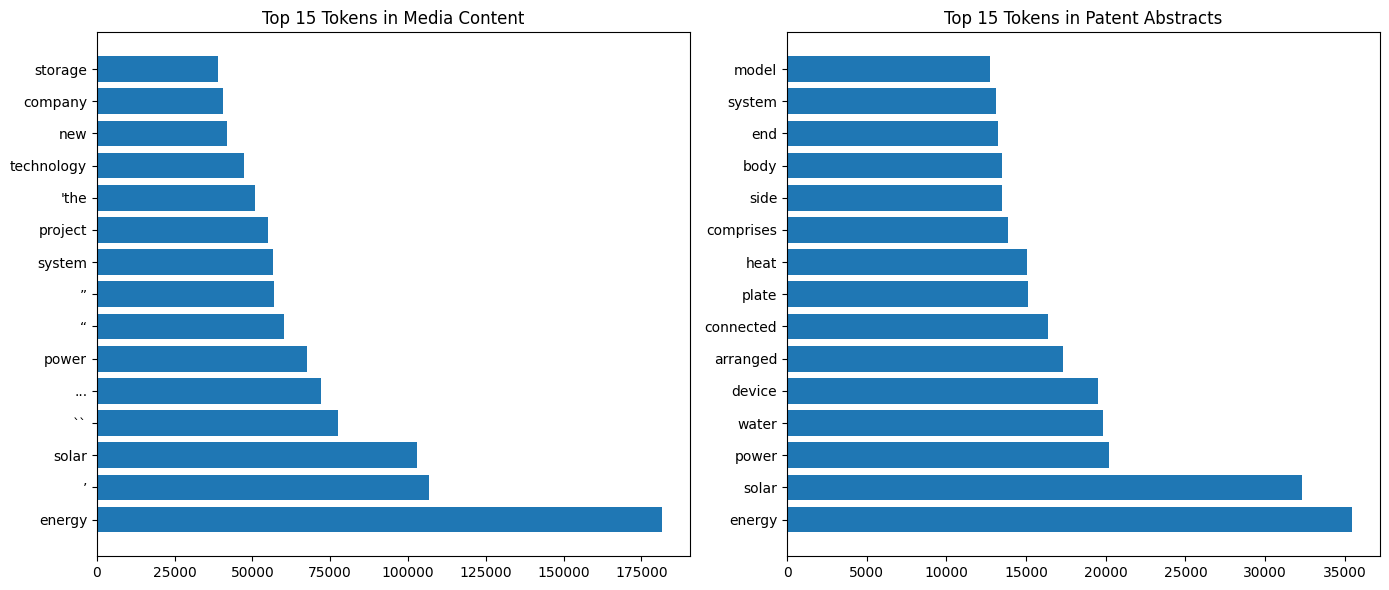

In [15]:

from collections import Counter

media_tokens  = [tok for toks in articles_df['tokens_content'] for tok in toks]
patent_tokens = [tok for toks in patent_df['tokens_abstract']  for tok in toks]

media_top  = Counter(media_tokens).most_common(15)
patent_top = Counter(patent_tokens).most_common(15)

m_terms, m_counts = zip(*media_top)
p_terms, p_counts = zip(*patent_top)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

ax1.barh(m_terms[::-1], m_counts[::-1])
ax1.set_title("Top 15 Tokens in Media Content")
ax1.invert_yaxis()

ax2.barh(p_terms[::-1], p_counts[::-1])
ax2.set_title("Top 15 Tokens in Patent Abstracts")
ax2.invert_yaxis()

plt.tight_layout()
plt.show()

### Insights from Token Frequency Comparison

The side by side bar charts above reveal clear differences in vocabulary emphasis between media articles and patent abstracts:

- **Media Content**  
  - Dominated by broad, thematic terms like **“energy,” “solar,”** and **“power.”**  
  - A heavier tail of general language tokens (e.g., punctuation artifacts) suggests we may want to extend our stop-word list before topic modeling.

- **Patent Abstracts**  
  - Still feature **“energy”** and **“solar,”** but with a stronger focus on technical components like **“device,” “water,”** and **“plate.”**  
  - Terms such as **“arranged,” “connected,”** and **“body”** reflect procedural descriptions typical of patent language.

**Takeaways:**   
When we will craft the QA Pairs, we should consider leverage these domain keywords to guide prompts e.g., asking about “device configurations” in patents, or “market trends” in media.  


## Utility & Visualization Functions

In this section, we define a suite of helper functions to inspect and visualize our generated QA pairs:

1. **`show_questions(title, questions, n)`**  
   Quickly prints the first `n` questions under a given `title`, making it easy to spot-check question quality or category samples.

2. **`gpt4_tokenizer(text)`**  
   Leverages the GPT-4 tokenizer (`tiktoken`) to split any text into model-level tokens, which is useful for estimating cost or prompt length.

3. **`plot_character_distribution(df)`**  
   - Plots a histogram (with KDE) of character lengths in the `question` column.  
   - Draws vertical lines for the mean (green) and median (red) to highlight overall length trends.

4. **`plot_word_distribution(df)`**  
   - Similar to the above, but for word counts (splitting on spaces).  
   - Helps you gauge how verbose or concise your questions are.

5. **`plot_gpt4_token_distribution(df)`**  
   - Tokenizes all questions via `gpt4_tokenizer`, filters to alphabetic tokens, and plots the top 20 most common tokens.  
   - Reveals dominant vocabulary before and after stop-word filtering.

6. **`plot_non_stopword_token_distribution(df)`**  
   - Builds on the GPT-4 token plot but further removes spaCy stop-words.  
   - Surfaces the most informative, domain-specific tokens used in your questions.

7. **`printwrap(text, wrap_length=80)`**  
   A simple text-wrapping utility that formats long strings to a specified line width, improving readability in console outputs.

Use these functions throughout the notebook to audit question lengths, token usage, and sample content essential steps for refining prompt strategies and ensuring your QA pairs are well-balanced.  


In [31]:

def show_questions(title: str, questions: list, n: int = 6) -> None:
    """
    Display the first n questions from the given list with a title.

    Parameters:
    - title: A string to display as the category title.
    - questions: A list of questions.
    - n: The maximum number of questions to display (default is 6).
    """
    print(title)
    print("-" * len(title))
    for idx, question in enumerate(questions[:n], start=1):
        print(f"{idx}. {question}")
    print()



def gpt4_tokenizer(text: str):
    """
    Tokenizes the text using the GPT-4 tokenizer from tiktoken.
    Returns a list of token strings.
    """
    token_ids = encoding.encode(text)
    tokens = [encoding.decode([tid]) for tid in token_ids]
    return tokens

def plot_character_distribution(df):
    """
    Plots a histogram (with KDE) of the character lengths in the 'question' column.
    Displays vertical lines for the median and mean character counts.
    """
    char_lengths = df["question"].map(len)
    sns.histplot(char_lengths, kde=True)
    plt.title("Amount of characters in questions")
    plt.xlabel("Amount of characters")
    plt.ylabel("Number of questions")

    median_char_len = char_lengths.median()
    mean_char_len = char_lengths.mean()
    plt.axvline(median_char_len, color='r', linestyle='--', label=f"Median: {median_char_len:.2f}")
    plt.axvline(mean_char_len, color='g', linestyle='--', label=f"Mean: {mean_char_len:.2f}")
    plt.legend()
    plt.show()

def plot_word_distribution(df):
    """
    Plots a histogram (with KDE) of the word counts in the 'question' column.
    Displays vertical lines for the median and mean word counts.
    """
    word_counts = df["question"].map(lambda x: len(x.split()))
    sns.histplot(word_counts, kde=True)
    plt.title("Amount of words in questions")
    plt.xlabel("Amount of words")
    plt.ylabel("Number of questions")

    median_word_count = word_counts.median()
    mean_word_count = word_counts.mean()
    plt.axvline(median_word_count, color='r', linestyle='--', label=f"Median: {median_word_count:.2f}")
    plt.axvline(mean_word_count, color='g', linestyle='--', label=f"Mean: {mean_word_count:.2f}")
    plt.legend()
    plt.show()

def plot_gpt4_token_distribution(df):
    """
    Uses the GPT-4 tokenizer to tokenize the 'question' column,
    filters out non-alphabetic tokens, counts the top 20 most common tokens,
    and displays a horizontal barplot.
    """
    questions = df['question'].tolist()

    all_tokens = [token for question in questions for token in gpt4_tokenizer(question)]

    alpha_tokens = [token.strip().lower() for token in all_tokens if token.strip().isalpha()]

    alpha_token_counts = Counter(alpha_tokens)
    top_tokens = alpha_token_counts.most_common(20)

    if top_tokens:
        tokens, counts = zip(*top_tokens)
        sns.barplot(x=list(counts), y=list(tokens))
        plt.title("Most common alphabetic tokens")
        plt.xlabel("Count")
        plt.ylabel("Token")
        plt.show()
    else:
        print("No tokens found after filtering.")

def plot_non_stopword_token_distribution(df):
    """
    Uses the GPT-4 tokenizer to tokenize the 'question' column,
    filters out non-alphabetic tokens and then filters out stopwords using spaCy.
    It then counts the top 20 most common non-stopword tokens and displays a horizontal barplot.
    """
    questions = df['question'].tolist()

    all_tokens = [token for question in questions for token in gpt4_tokenizer(question)]
    alpha_tokens = [token.strip().lower() for token in all_tokens if token.strip().isalpha()]
    non_stop_tokens = [token for token in alpha_tokens if not nlp.vocab[token].is_stop]
    non_stop_token_counts = Counter(non_stop_tokens)
    top_tokens = non_stop_token_counts.most_common(20)

    if top_tokens:
        tokens, counts = zip(*top_tokens)
        sns.barplot(x=list(counts), y=list(tokens))
        plt.title("Most common non-stopword tokens")
        plt.xlabel("Count")
        plt.ylabel("Token")
        plt.show()
    else:
        print("No non-stop tokens found after filtering.")

def printwrap(text, wrap_lenght = 80):
  wrapped_text = textwrap.fill(text,wrap_lenght)
  return wrapped_text

### Selection of Important Paragraphs
To generate robust QA pairs, we first identified key paragraphs in our dataset. We selected paragraphs based on relevance, informativeness, and their potential to generate high-quality questions and answers.

***Process Overview:***

  - **Domain Filtering:**
    We separated the data into 5 domains: "azocleantech", "solarindustrymag", "cleantechnica", "pv-magazine", and "energyvoice", ensuring relevance to our project.

  - **Manual Selection by Index:**
    After filtering by domain, we manually selected high-quality paragraphs based on content. For example, we selected 7 paragraphs from "azocleantech" and 8 from "solarindustrymag", saving them in a CSV file. These selections cover diverse cleantech topics to ensure varied input for QA generation.

  - **Language Filter:**
    We focused exclusively on English examples for consistency with the tutorial's approach. For more details, refer to the [Cleantech RAG Tutorial](https://github.com/LuciferUchiha/Cleantech-RAG/blob/main/cleantech_rag.ipynb).


In [16]:
azocleantech_df = articles_df[articles_df['domain']=='azocleantech']

In [17]:
solarindustrymag_df = articles_df[articles_df['domain']=='solarindustrymag']

In [18]:
pv_magazine_df = articles_df[articles_df['domain']=='pv-magazine']

In [19]:
energyvoice_df = articles_df[articles_df['domain']=='energyvoice']

In [20]:
cleantechnica_df = articles_df[articles_df['domain']=='cleantechnica']

###Paragraphs for azocleantech domain

In [21]:
# 7 paragraphs of azocleantech_df
selected_indices = [17690, 17915, 18349, 17715, 19247, 15788, 2195]
paragraphs_azocleantech_df = azocleantech_df.loc[selected_indices]

In [23]:
paragraphs_azocleantech_df.head(2)

,Unnamed: 0,title,date,author,content,domain,url,tokens_title,tokens_content
17690,23302,Renewable Energy Partnerships: Green Hydrogen Integration,2024-05-01,NaN,"['As we move toward a sustainable future, green hydrogen is a significant player in the renewabl...",azocleantech,https://www.azocleantech.com/article.aspx?ArticleID=1823,"[renewable, energy, partnership, green, hydrogen, integration]","['as, move, toward, sustainable, future, green, hydrogen, significant, player, renewable, energy..."
17915,23338,Asahi Kasei Starts Operation of Multi-Module Hydrogen Pilot Plant in Kawasaki,2024-05-15,NaN,['The Japanese technology company Asahi Kasei is further accelerating its hydrogen business acti...,azocleantech,https://www.azocleantech.com/news.aspx?newsID=34871,"[asahi, kasei, start, operation, multi-module, hydrogen, pilot, plant, kawasaki]","['the, japanese, technology, company, asahi, kasei, accelerating, hydrogen, business, activity, ..."


###Paragraphs for solarindustrymag domain

In [24]:
# 8 paragraphs of solarindustrymag_df

selected_indices = [14,4307,1513,2216,13545,13382,2344,1578]
paragraphs_solarindustrymag_df = solarindustrymag_df.loc[selected_indices]

In [25]:
paragraphs_solarindustrymag_df.head(2)

,Unnamed: 0,title,date,author,content,domain,url,tokens_title,tokens_content
14,63200,NREL Project Investigates Wind Condition Impacts on Solar Power Structures,2022-01-04,NaN,['High wind loads increase structural design costs of concentrating solar power ( CSP) collector...,solarindustrymag,https://solarindustrymag.com/nrel-project-investigates-wind-condition-impacts-on-solar-power-str...,"[nrel, project, investigates, wind, condition, impact, solar, power, structure]","['high, wind, load, increase, structural, design, cost, concentrating, solar, power, csp, collec..."
4307,63461,Energy Vault Deploying 440 MWh Nevada Energy Storage System for NV Energy,2022-12-12,NaN,"['NV Energy, Nevada’ s largest public utility, has awarded Energy Vault Holdings Inc. with a pro...",solarindustrymag,https://solarindustrymag.com/energy-vault-deploys-440-mwh-nevada-energy-storage-system-for-nv-en...,"[energy, vault, deploying, 440, mwh, nevada, energy, storage, system, nv, energy]","['nv, energy, nevada, ’, largest, public, utility, awarded, energy, vault, holding, inc., projec..."


###Paragraphs for pv-magzine domain

In [26]:
pv_magazine_indices=[1311, 1416, 14590, 16840, 17599, 17643, 18321, 18854, 18906, 19194]
paragraphs_pv_magazine_df = pv_magazine_df.loc[pv_magazine_indices]


In [27]:
paragraphs_pv_magazine_df.head(2)

,Unnamed: 0,title,date,author,content,domain,url,tokens_title,tokens_content
1311,98356,South Korea tests photovoltaics on railroad noise barriers – pv magazine International,2022-04-21,NaN,['Land-scarce South Korea is currently hosting a series of initiatives aimed at deploying solar ...,pv-magazine,https://www.pv-magazine.com/2022/04/21/south-korea-tests-photovoltaics-on-railroad-noise-barriers/,"[south, korea, test, photovoltaics, railroad, noise, barrier, –, pv, magazine, international]","['land-scarce, south, korea, currently, hosting, series, initiative, aimed, deploying, solar, un..."
1416,98368,Quebec publishes draft documents for 1.3 GW tender – pv magazine International,2022-04-27,NaN,"['The Canadian provincial government’ s Green Economy Plan, launched in November 2020, envisages...",pv-magazine,https://www.pv-magazine.com/2022/04/27/quebec-publishes-draft-documents-for-1-3-gw-tender/,"[quebec, publishes, draft, document, 1.3, gw, tender, –, pv, magazine, international]","['the, canadian, provincial, government, ’, green, economy, plan, launched, november, 2020, envi..."


###Paragraphs for energyvoice domain

In [28]:
energyvoice_indices=[870, 2204, 2979, 3255, 4605, 5268, 6320, 12599, 12647, 18538]
paragraphs_energyvoice_df = energyvoice_df.loc[energyvoice_indices]

In [29]:
paragraphs_energyvoice_df.head(2)

,Unnamed: 0,title,date,author,content,domain,url,tokens_title,tokens_content
870,42863,Patrick Harvie: Ukraine invasion doesn't justify North Sea production boost,2022-03-14,NaN,['Scottish Green party co-leader Patrick Harvie has said the war in Ukraine must not be used to ...,energyvoice,https://www.energyvoice.com/oilandgas/europe/395102/north-sea-patrick-harvie/,"[patrick, harvie, ukraine, invasion, n't, justify, north, sea, production, boost]","['scottish, green, party, co-leader, patrick, harvie, said, war, ukraine, must, used, justify, i..."
2204,42960,Port of Nigg’ s new quay ready to play leading role in renewables boom,2022-07-05,NaN,['Port of Nigg has unveiled its new East Quay following a multimillion-pound investment to incre...,energyvoice,https://www.energyvoice.com/renewables-energy-transition/424759/port-of-niggs-new-quay-ready-to-...,"[port, nigg, ’, new, quay, ready, play, leading, role, renewables, boom]","['port, nigg, unveiled, new, east, quay, following, multimillion-pound, investment, increase, ca..."


###Paragraphs for cleantechnica domain

In [30]:
filtered_indices = cleantechnica_df.index[cleantechnica_df["Unnamed: 0"].isin(
    [95438, 95392, 95363, 95261, 95173, 95163, 95133, 95106,
     95074, 94927, 94925, 94662, 94668, 94645, 95411]
)].tolist()

In [31]:
paragraphs_cleantechnica_df = cleantechnica_df.loc[filtered_indices]

In [32]:
paragraphs_cleantechnica_df.head(2)

,Unnamed: 0,title,date,author,content,domain,url,tokens_title,tokens_content
7568,94645,Cruise Robotaxis Entering More Cities,2023-05-17,NaN,['Cruise has slowly been expanding its network of robotaxis and their availability in certain ma...,cleantechnica,https://cleantechnica.com/2023/05/17/cruise-robotaxis-entering-more-cities/,"[cruise, robotaxis, entering, city]","['cruise, slowly, expanding, network, robotaxis, availability, certain, market, though, ’, long,..."
7619,94668,"Philippine Electric Vehicle Association Receives Award, Attends EV Meetings in Korea",2023-05-21,NaN,"['JEJU, SOUTH KOREA — EVAP, the Electric Vehicle Association of the Philippines, recently partic...",cleantechnica,https://cleantechnica.com/2023/05/21/philippine-electric-vehicle-association-receives-awards-att...,"[philippine, electric, vehicle, association, receives, award, attends, ev, meeting, korea]","['jeju, south, korea, —, evap, electric, vehicle, association, philippine, recently, participate..."


### Merging Paragraphs from Multiple Media Sources

To build a comprehensive corpus for QA generation and topic analysis, we combine the paragraph level DataFrames from above into one unified DataFrame

In [33]:
combined_df = pd.concat([paragraphs_azocleantech_df,
                         paragraphs_solarindustrymag_df,
                         paragraphs_pv_magazine_df,
                         paragraphs_energyvoice_df,
                         paragraphs_cleantechnica_df],
                        ignore_index=True)

In [34]:
data_folder = Path("./data")
if not data_folder.exists():
    data_folder.mkdir()



In [35]:
combined_df.to_csv("data/paragraphs_media_dataset.csv")

In [37]:
combined_df.head(3)

,Unnamed: 0,title,date,author,content,domain,url,tokens_title,tokens_content
0,23302,Renewable Energy Partnerships: Green Hydrogen Integration,2024-05-01,NaN,"['As we move toward a sustainable future, green hydrogen is a significant player in the renewabl...",azocleantech,https://www.azocleantech.com/article.aspx?ArticleID=1823,"[renewable, energy, partnership, green, hydrogen, integration]","['as, move, toward, sustainable, future, green, hydrogen, significant, player, renewable, energy..."
1,23338,Asahi Kasei Starts Operation of Multi-Module Hydrogen Pilot Plant in Kawasaki,2024-05-15,NaN,['The Japanese technology company Asahi Kasei is further accelerating its hydrogen business acti...,azocleantech,https://www.azocleantech.com/news.aspx?newsID=34871,"[asahi, kasei, start, operation, multi-module, hydrogen, pilot, plant, kawasaki]","['the, japanese, technology, company, asahi, kasei, accelerating, hydrogen, business, activity, ..."
2,23355,Global Warming Threatens Hudson Bay Polar Bears,2024-06-14,NaN,"['Recent research by Julienne Stroeve and colleagues, published in Communications Earth & Enviro...",azocleantech,https://www.azocleantech.com/news.aspx?newsID=34952,"[global, warming, threatens, hudson, bay, polar, bear]","['recent, research, julienne, stroeve, colleague, published, communication, earth, environment, ..."


## 3. QA Pair Generation

We use Llama 3.2 Instruct model and Deepseek R1 to generate QA pairs from selected paragraphs. Each generated question and answer is tied to specific cleantech-related content, providing context for later analysis.

For the **media dataset**, the QA pairs include:

  - **question**: The generated question.
  - **relevant_text**: The text (paragraph) used as context.
  - **answer**: The generated answer.
  - **article_url**: The URL of the source article.

For the **patent dataset**, the QA pairs contain additional metadata:

  - **question**: The generated question.
  - **relevant_text**: The abstract used as context.
  - **answer**: The generated answer.
  - **title**: The patent title.
  - **publication_date**: The patent publication date.
  - **inventor**: The inventor(s) associated with the patent.

Note:
Generating hundreds of QA pairs with Llama 3.2 Instruct and Deepseek R1  can be very time consuming, so we’ve provided the completed CSVs here. In th cell above, we simply load the media QA file and inspect their structure

### QA Pairs with Llama 3.2


#### Generate the QA Pairs for the Media Dataset

In [ ]:
from openai import OpenAI
import pandas as pd
import re

def generate_qa_pairs_media(df, target_qa_pairs=43, dataset_type="media",model = "meta-llama/llama-3.2-3b-instruct"):
    """
    Generates QA pairs from a given DataFrame using Llama 3.2 Instruct.

    Parameters:
      df (pd.DataFrame): DataFrame containing the reference texts.
         For the media dataset, it is expected to have a 'content' column and 'url'.
         For the patent dataset, it is expected to have an 'abstract' column, 'title',
         'publication_date', and 'inventor'.
      target_qa_pairs (int): The target number of QA pairs to generate.
      dataset_type (str): Specifies the dataset type. Use "media" for the media dataset,
         and "patent" for the patent dataset.

    Returns:
      pd.DataFrame: DataFrame containing the generated QA pairs and the associated metadata.
    """
    qa_pairs = []

    for _, row in df.iterrows():
        if dataset_type.lower() == "media":
            context_text = row['content']
        elif dataset_type.lower() == "patent":
            context_text = row['abstract']
        else:
            raise ValueError("dataset_type must be either 'media' or 'patent'.")

        paragraphs = context_text.split("\n\n")

        for paragraph in paragraphs:
            if not paragraph.strip():
                continue

            prompt = (
            "Using the following text, generate 15 unique and meaningful question–answer pairs.\n\n"
            "Instructions:\n"
            "1. Questions should be varied: include what, who, when, where, why, and how as appropriate.\n"
            "2. Focus on important details, facts, or concepts mentioned in the text.\n"
            "3. Provide clear answers that explain the key idea without being overly brief or too long.\n"
            "4. Format each pair as follows:\n"
            "Q: [Your question here]\n"
            "A: [Your answer here]\n\n"
            "Separate each Q&A pair with a blank line.\n\n"
            f"Text:\n{paragraph.strip()}"
        )


            try:
                completion = client.chat.completions.create(
                    model=model,
                    messages=[{"role": "user", "content": prompt}],
                )

                response = completion.choices[0].message.content.strip()

                # Extract Q&A pairs from the response
                qa_text = re.findall(r"Q:\s*(.*?)\s*A:\s*(.*?)(?=\nQ:|\Z)", response, re.DOTALL)

                for question, answer in qa_text:
                    if not any(existing["question"] == question for existing in qa_pairs):
                        if dataset_type.lower() == "media":
                            qa_pair = {
                                "question": question.strip(),
                                "relevant_text": paragraph.strip(),
                                "answer": answer.strip(),
                                "article_url": row.get('url', '')
                            }
                        else:
                            qa_pair = {
                                "question": question.strip(),
                                "relevant_text": paragraph.strip(),
                                "answer": answer.strip(),
                                "title": row.get('title', ''),
                                "publication_date": row.get('publication_date', ''),
                                "inventor": row.get('inventor', '')
                            }

                        qa_pairs.append(qa_pair)

                    if len(qa_pairs) >= target_qa_pairs:
                        break

            except Exception as e:
                print(f"Error: {e}")
                continue

        if len(qa_pairs) >= target_qa_pairs:
            break

    return pd.DataFrame(qa_pairs)


In [ ]:
media_qa_df_llama = generate_qa_pairs_media(combined_df, target_qa_pairs=800, dataset_type="media")
media_qa_df_llama.to_csv("data/media_qa_df_llama.csv", index= False)


Since generating QA pairs can be very time consuming, we’ve pre-created and saved the media QA DataFrame to `datasets/media_qa_df_llama.csv`. Here, we simply load it and take a quick peek at the first few entries:

In [74]:
media_qa_df_llama = pd.read_csv("datasets/media_qa_df_llama.csv")

In [75]:
media_qa_df_llama.head(5)[["question","answer"]]

,question,answer
0,"What is green hydrogen, and how is it produced?",Green hydrogen is a sustainable energy carrier produced by water electrolysis using renewable en...
1,Who are some of the key players involved in the development and adoption of green hydrogen?,"Key players include companies like Siemens Energy, ITM Power, and H2Pro, as well as academia and..."
2,What are the main challenges associated with integrating green hydrogen into the energy grid?,"The main challenges include technical hurdles such as lower energy efficiency, safe storage and ..."
3,What is the role of the European Union's Hydrogen Strategy in promoting green hydrogen adoption?,"The strategy aims to significantly ramp up green hydrogen production by 2030, providing financia..."
4,"How does the Hydrogen Council facilitate partnerships and collaboration among companies, governm...","The Hydrogen Council brings together over 80 energy, transport, and industrial companies worldwi..."


### Generate the QA Pairs for the Patent Dataset
For the patent dataset, we begin by filtering the articles based on keywords relevant to cleantech (using two keyword sets for azocleantech and solarindustrymag). Patents do not come pre-categorized into domains like media articles, so we must generate QA pairs first and then apply a separate categorization process.

To extract patents relevant to cleantech topics, we use a deterministic, rule-based approach.

- We start by defining two lists of keywords:
- Next, we apply these lists to the patent dataset by examining the abstract field of each patent. Using a lambda function with the apply method, we deterministically check if any keyword exists in an abstract. This yields two Boolean masks indicating whether a patent belongs to the azocleantech or solarindustrymag domain, respectively. We then filter the dataset based on these masks.
- We decided to use a deterministic, rule-based approach because we can directly see which keywords triggered the classification, allowing us to easily audit and refine our keyword lists if needed.
- However, we are aware that this method is rigid, so if an abstract uses synonyms or slightly different phrasing that isn’t in our keyword list, it might not be classified correctly. The approach does not consider context or the possibility of words having multiple meanings. An abstract might mention a keyword in a context that does not pertain to cleantech.

By using this deterministic approach, we ensure that our patent dataset is filtered in a consistent and transparent manner. While this method is efficient and straightforward, it does have limitations regarding flexibility and nuance.

In [ ]:
# patent_df_related = pd.read_csv('datasets/patent_df_selected_abstracts.csv')


In [42]:
patent_df.head(3)

,publication_number,application_number,country_code,title_localized,abstract_localized,publication_date,inventor,cpc,tokens_title,tokens_abstract
0,US-2022239235-A1,US-202217717397-A,US,"[{'text': 'Adaptable DC-AC Inverter Drive System and Operation', 'language': 'en', 'truncated': ...",[{'text': 'Disclosed is an adaptable DC-AC inverter system and its operation. The system include...,20220728,[],"[{'code': 'H02M7/5395', 'inventive': True, 'first': False, 'tree': []}, {'code': 'H02J3/32', 'in...","[adaptable, dc-ac, inverter, drive, system, operation]","[disclosed, adaptable, dc-ac, inverter, system, operation, system, includes, multiple, dc, input..."
1,US-2022239251-A1,US-202217580956-A,US,[{'text': 'System for providing the energy from a single contiguous solar energy structure to at...,"[{'text': 'In accordance with an example embodiment, a solar energy system comprises: a solar en...",20220728,[],"[{'code': 'H02S40/38', 'inventive': True, 'first': False, 'tree': []}, {'code': 'G01R22/061', 'i...","[system, providing, energy, single, contiguous, solar, energy, structure, least, two, different,...","[accordance, example, embodiment, solar, energy, system, comprises, solar, energy, structure, co..."
2,EP-4033090-A1,EP-21152924-A,EP,"[{'text': 'Verfahren zum steuern einer windenergieanlage', 'language': 'de', 'truncated': False}...","[{'text': 'Verfahren zum Steuern einer Windenergieanlage (100), wobei die Windenergieanlage (100...",20220727,"[Schaper, Ulf, von Aswege, Enno, Gerke Funcke, Paul]","[{'code': 'F03D7/0276', 'inventive': True, 'first': True, 'tree': []}, {'code': 'F03D7/0296', 'i...","[verfahren, zum, steuern, einer, windenergieanlage]","[verfahren, zum, steuern, einer, windenergieanlage, 100, wobei, die, windenergieanlage, 100, ein..."


#### Extracting & Combining Patent Text Fields

In this step, we unpack the localized title and abstract lists to create usable text and metadata columns:

1. **Language Extraction**  
   - `title_lang`: the language code of the first entry in `title_localized`.  
   - `abstract_lang`: likewise for `abstract_localized`.  

2. **Text Extraction**  
   - `title_text`: the actual title string from `title_localized`.  
   - `abstract_text`: the abstract text from `abstract_localized`.  

3. **Concatenate & Word Count**  
   - `total`: joins `title_text` and `abstract_text` into a single field for each patent.  
   - `w_count`: counts the words in `total`, giving us a quick measure of document length for downstream filtering or sampling.


In [43]:
patent_df['title_lang'] = patent_df['title_localized'].apply(lambda x:x[0]['language'])
patent_df['abstract_lang'] = patent_df['abstract_localized'].apply(lambda x:x[0]['language'])

patent_df['title_text'] = patent_df['title_localized'].apply(lambda x:x[0]['text'])
patent_df['abstract_text'] = patent_df['abstract_localized'].apply(lambda x:x[0]['text'])

patent_df['total'] = patent_df['title_text']+patent_df['abstract_text']

In [44]:
patent_df['w_count'] = patent_df['total'].apply(lambda x:len(x.split()))

In [45]:
patent_df.head(2)

,publication_number,application_number,country_code,title_localized,abstract_localized,publication_date,inventor,cpc,tokens_title,tokens_abstract,title_lang,abstract_lang,title_text,abstract_text,total,w_count
0,US-2022239235-A1,US-202217717397-A,US,"[{'text': 'Adaptable DC-AC Inverter Drive System and Operation', 'language': 'en', 'truncated': ...",[{'text': 'Disclosed is an adaptable DC-AC inverter system and its operation. The system include...,20220728,[],"[{'code': 'H02M7/5395', 'inventive': True, 'first': False, 'tree': []}, {'code': 'H02J3/32', 'in...","[adaptable, dc-ac, inverter, drive, system, operation]","[disclosed, adaptable, dc-ac, inverter, system, operation, system, includes, multiple, dc, input...",en,en,Adaptable DC-AC Inverter Drive System and Operation,Disclosed is an adaptable DC-AC inverter system and its operation. The system includes multiple ...,Adaptable DC-AC Inverter Drive System and OperationDisclosed is an adaptable DC-AC inverter syst...,70
1,US-2022239251-A1,US-202217580956-A,US,[{'text': 'System for providing the energy from a single contiguous solar energy structure to at...,"[{'text': 'In accordance with an example embodiment, a solar energy system comprises: a solar en...",20220728,[],"[{'code': 'H02S40/38', 'inventive': True, 'first': False, 'tree': []}, {'code': 'G01R22/061', 'i...","[system, providing, energy, single, contiguous, solar, energy, structure, least, two, different,...","[accordance, example, embodiment, solar, energy, system, comprises, solar, energy, structure, co...",en,en,System for providing the energy from a single contiguous solar energy structure to at least two ...,"In accordance with an example embodiment, a solar energy system comprises: a solar energy struct...",System for providing the energy from a single contiguous solar energy structure to at least two ...,109


To understand the range of patent text sizes we’ll be working with, we plot a histogram (with KDE) of the combined word counts for each patent’s title + abstract

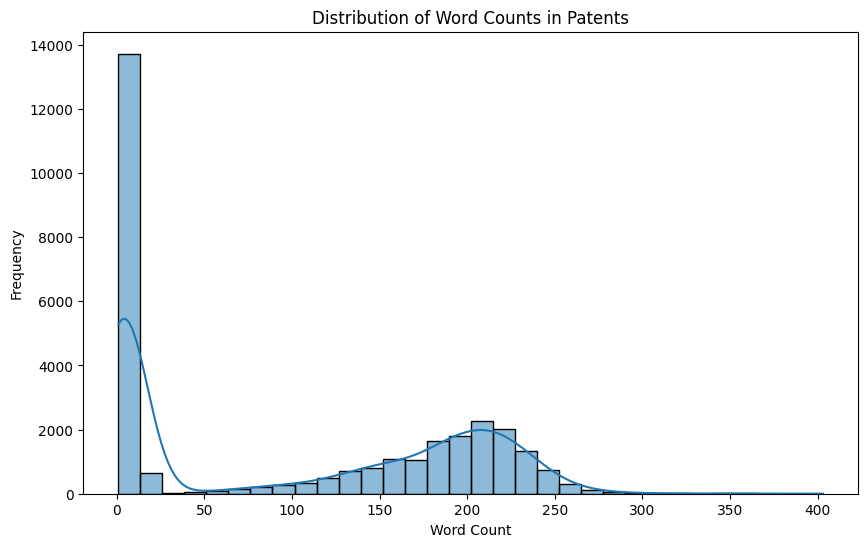

In [ ]:
plt.figure(figsize=(10, 6))
sns.histplot(patent_df['w_count'], kde=True)
plt.title('Distribution of Word Counts in Patents')
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.show()


There’s a large spike at very low word counts (near zero), indicating some records with missing or extremely short abstracts/titles.

The bulk of patents fall in the 150–250 word range, reflecting typical abstract + title lengths.

A long tail beyond 300 words suggests a few particularly verbose patents.

We want to filter out extremely short records (e.g., w_count < 20) to avoid generating trivial or uninformative QA pairs.

#### Language Distribution in Patent Titles vs. Abstracts

Here we check which language combinations appear in our patent records

In [ ]:
display(patent_df[['title_lang','abstract_lang']].value_counts())


title_lang  abstract_lang
en          en               8297
zh          zh               7741
en          zh               6624
zh          en               6463
fr          en                226
de          en                128
en          fr                126
fr          fr                 64
de          de                 38
en          ko                 34
ko          ko                 29
fr          de                 28
de          fr                 28
ru          ru                 26
fr          ko                 24
en          de                 22
ru          en                 20
zh          fr                 18
en          ru                 14
fr          zh                 12
ar          ar                  6
es          fr                  6
en          es                  6
es          en                  6
en          hr                  4
            ar                  4
he          en                  2
en          pl                  2
sr          sr        

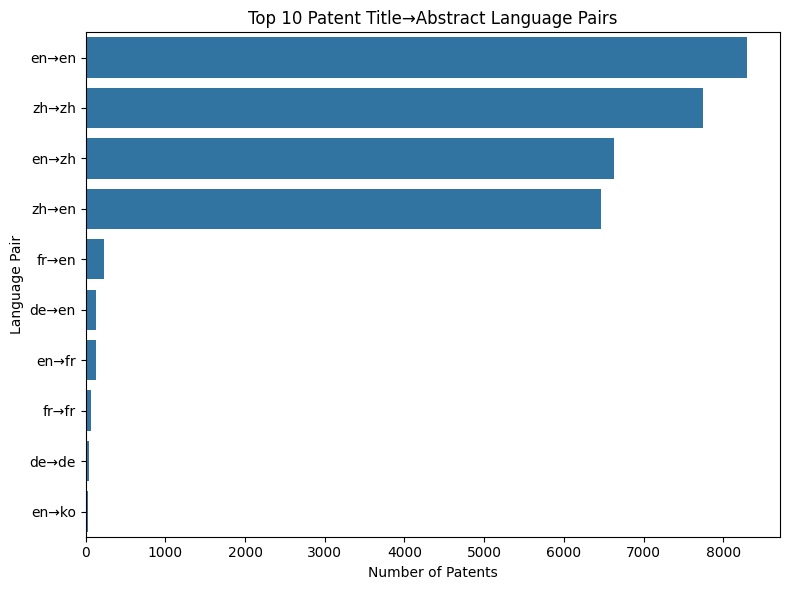

In [46]:

lang_pairs = (
    patent_df[['title_lang', 'abstract_lang']]
    .value_counts()
    .reset_index(name='count')
    .assign(pair=lambda df: df['title_lang'] + '→' + df['abstract_lang'])
)

plt.figure(figsize=(8, 6))
sns.barplot(
    data=lang_pairs.nlargest(10, 'count'),
    x='count',
    y='pair'
)
plt.title("Top 10 Patent Title→Abstract Language Pairs")
plt.xlabel("Number of Patents")
plt.ylabel("Language Pair")
plt.tight_layout()
plt.show()



####  Filtering to English & Minimum Length

To focus on fully English patents with substantive content, we filter out any records where either the title or abstract isn’t in English, and where the combined text is too short to yield meaningful Q&A. Specifically:

- Keep only patents with `title_lang == 'en'` **and** `abstract_lang == 'en'`.  
- Exclude any patents whose `w_count` (title + abstract word count) is ≤ 20.

This reduces our set to 15,673 out of the original ~30,000 patents:



In [47]:
clean_patent_df = patent_df[(patent_df['title_lang'] == 'en')*(patent_df['abstract_lang'] == 'en')*(patent_df['w_count']>20)]


In [48]:
len(clean_patent_df)

8296

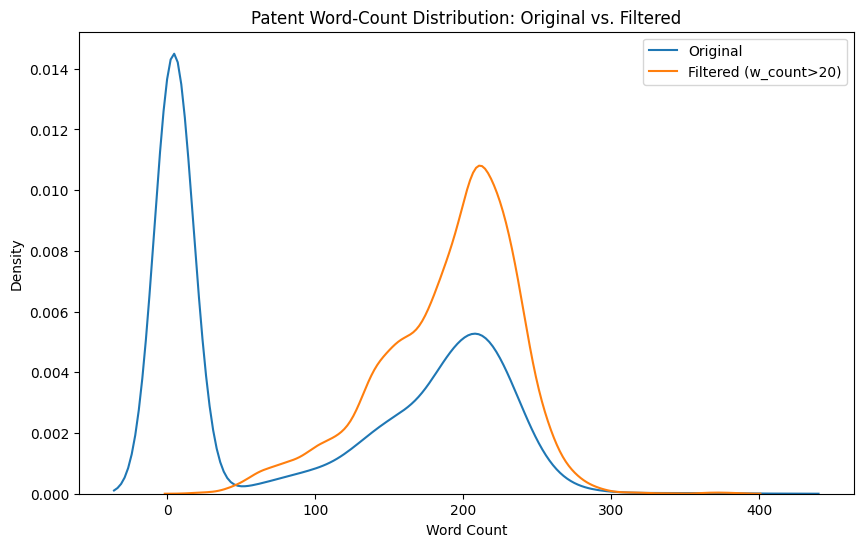

In [49]:

plt.figure(figsize=(10, 6))
sns.kdeplot(patent_df['w_count'], label='Original', bw_adjust=1)
sns.kdeplot(clean_patent_df['w_count'], label='Filtered (w_count>20)', bw_adjust=1)
plt.title("Patent Word-Count Distribution: Original vs. Filtered")
plt.xlabel("Word Count")
plt.ylabel("Density")
plt.legend()
plt.show()


  The original distribution (blue) has a sharp peak near zero due to very short or empty abstracts.

  After filtering (orange), that peak disappears, and the bulk of patents centers around 150–250 words.

  This confirms we’ve removed trivial entries while retaining the core body of substantive patents—ideal for generating meaningful QA pairs.



####  Topic Modeling on Cleaned Patent Texts

Now that we have tokenized and preprocessed our patent texts, we’ll use Gensim’s LDA to surface the main themes across patents:

1. **Prepare the Data**  
   - Apply our `preprocess_text` function to the combined `title + abstract` (`total`) field, storing the result in `clean_tokens`.  
   - Collect these token lists as `processed_docs`.

2. **Build Dictionary & Corpus**  
   - `dictionary = corpora.Dictionary(processed_docs)` creates a mapping of each unique token to an integer ID.  
   - `corpus = [dictionary.doc2bow(doc) for doc in processed_docs]` converts each document into a bag-of-words (token ID, count) format.

3. **Train the LDA Model**

  were we choose the top 10 topics  

  lda_model = gensim.models.LdaMulticore(
       corpus=corpus,
       id2word=dictionary,
       num_topics=10,     # we choose 10 topics
       passes=10,          # 10 full corpus passes
       workers=4          # parallelize across 4 CPU cores
   )


In [ ]:

import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from gensim import corpora



clean_patent_df['clean_tokens'] = clean_patent_df['total'].apply(preprocess_text)
processed_docs = clean_patent_df['clean_tokens']

# create a dictionary and corpus
dictionary = corpora.Dictionary(processed_docs)
corpus = [dictionary.doc2bow(doc) for doc in processed_docs]

# apply LDA topic modeling
lda_model = gensim.models.LdaMulticore(corpus=corpus, id2word=dictionary, num_topics=10, passes=10, workers=4)

for idx, topic in lda_model.print_topics(-1):
    print(f"Topic: {idx} \nWords: {topic}\n")

# find the dominant topic for each document
for index, row in clean_patent_df.iterrows():
    bow = dictionary.doc2bow(row['clean_tokens'])
    dominant_topic = max(lda_model[bow], key=lambda item: item[1])


Topic: 0 
Words: 0.026*"solar" + 0.025*"energy" + 0.015*"panel" + 0.011*"power" + 0.010*"water" + 0.009*"support" + 0.009*"system" + 0.009*"connected" + 0.008*"model" + 0.008*"heat"

Topic: 1 
Words: 0.017*"water" + 0.011*"energy" + 0.009*"comprises" + 0.009*"structure" + 0.009*"arranged" + 0.008*"end" + 0.008*"first" + 0.008*"photovoltaic" + 0.007*"solar" + 0.007*"mechanism"

Topic: 2 
Words: 0.032*"solar" + 0.031*"energy" + 0.015*"power" + 0.014*"storage" + 0.012*"water" + 0.011*"system" + 0.011*"device" + 0.010*"arranged" + 0.010*"panel" + 0.009*"model"

Topic: 3 
Words: 0.027*"energy" + 0.024*"heat" + 0.023*"solar" + 0.015*"hydrogen" + 0.015*"system" + 0.013*"water" + 0.012*"pipe" + 0.008*"body" + 0.008*"device" + 0.008*"connected"

Topic: 4 
Words: 0.020*"power" + 0.018*"device" + 0.016*"body" + 0.015*"solar" + 0.014*"module" + 0.014*"energy" + 0.013*"system" + 0.009*"connected" + 0.009*"control" + 0.008*"water"

Topic: 5 
Words: 0.013*"water" + 0.013*"device" + 0.012*"solar" + 0.

In [52]:
def get_top_words_and_docs(lda_model, corpus, dictionary, num_topics=10, top_words=10, top_docs=5):
    topic_results = []
    for topic_idx in range(num_topics):
        # get top words for the topic
        top_words_for_topic = [word for word, prob in lda_model.show_topic(topic_idx, top_words)]

        # get the documents with the highest probability for this topic
        topic_document_probs = []  # list to store document probabilities for this topic
        for doc_idx, doc_bow in enumerate(corpus):
          for topic_prob_idx, topic_prob in lda_model[doc_bow]:
            if topic_prob_idx == topic_idx:
              topic_document_probs.append((doc_idx, topic_prob))
              break  # move on to next document

        topic_document_probs.sort(key = lambda x: x[1], reverse=True)  # sort in descending order based on probability

        top_docs_for_topic = [doc_idx for doc_idx, _ in topic_document_probs[:top_docs]]


        topic_results.append({
            'topic_id': topic_idx,
            'top_words': top_words_for_topic,
            'top_documents': top_docs_for_topic
        })
    return topic_results


topic_results = get_top_words_and_docs(lda_model, corpus, dictionary)
document_indices = []
for topic in topic_results:
  print(f"Topic {topic['topic_id']}:")
  print("Top Words:", topic['top_words'])
  print("Top Documents:", topic['top_documents'])
  document_indices.extend(topic['top_documents'])
  print("-"*20)


Topic 0:
Top Words: ['solar', 'energy', 'panel', 'power', 'water', 'support', 'system', 'connected', 'model', 'heat']
Top Documents: [5300, 5303, 5304, 5509, 5511]
--------------------
Topic 1:
Top Words: ['water', 'energy', 'comprises', 'structure', 'arranged', 'end', 'first', 'photovoltaic', 'solar', 'mechanism']
Top Documents: [482, 530, 552, 4788, 1130]
--------------------
Topic 2:
Top Words: ['solar', 'energy', 'power', 'storage', 'water', 'system', 'device', 'arranged', 'panel', 'model']
Top Documents: [5572, 5569, 5588, 662, 3535]
--------------------
Topic 3:
Top Words: ['energy', 'heat', 'solar', 'hydrogen', 'system', 'water', 'pipe', 'body', 'device', 'connected']
Top Documents: [24, 25, 16, 2043, 2083]
--------------------
Topic 4:
Top Words: ['power', 'device', 'body', 'solar', 'module', 'energy', 'system', 'connected', 'control', 'water']
Top Documents: [2528, 2537, 1474, 1703, 3423]
--------------------
Topic 5:
Top Words: ['water', 'device', 'solar', 'energy', 'unit', '

In [53]:
patent_df_selected_abstracts = clean_patent_df.iloc[document_indices]


In [54]:
patent_df_selected_abstracts.head(2)

,publication_number,application_number,country_code,title_localized,abstract_localized,publication_date,inventor,cpc,tokens_title,tokens_abstract,title_lang,abstract_lang,title_text,abstract_text,total,w_count,clean_tokens
17713,CN-113486582-B,CN-202110760093-A,CN,[{'text': 'Modeling and speed regulation parameter optimization method and system for hydropower...,[{'text': 'The invention discloses a hydropower station modeling and speed regulation parameter ...,20220218,[],"[{'code': 'G06F2119/14', 'inventive': False, 'first': False, 'tree': []}, {'code': 'G06F2113/08'...","[modeling, speed, regulation, parameter, optimization, method, system, hydropower, station, doub...","[invention, discloses, hydropower, station, modeling, speed, regulation, parameter, optimization...",en,en,Modeling and speed regulation parameter optimization method and system for hydropower station wi...,The invention discloses a hydropower station modeling and speed regulation parameter optimizatio...,Modeling and speed regulation parameter optimization method and system for hydropower station wi...,253,"[modeling, speed, regulation, parameter, optimization, method, system, hydropower, station, doub..."
17716,CN-113486582-B,CN-202110760093-A,CN,[{'text': 'Modeling and speed regulation parameter optimization method and system for hydropower...,[{'text': 'The invention discloses a hydropower station modeling and speed regulation parameter ...,20220218,[],"[{'code': 'G06F2119/14', 'inventive': False, 'first': False, 'tree': []}, {'code': 'G06F2113/08'...","[modeling, speed, regulation, parameter, optimization, method, system, hydropower, station, doub...","[invention, discloses, hydropower, station, modeling, speed, regulation, parameter, optimization...",en,en,Modeling and speed regulation parameter optimization method and system for hydropower station wi...,The invention discloses a hydropower station modeling and speed regulation parameter optimizatio...,Modeling and speed regulation parameter optimization method and system for hydropower station wi...,253,"[modeling, speed, regulation, parameter, optimization, method, system, hydropower, station, doub..."


In [55]:
patent_df_selected_abstracts.to_csv('data/patent_df_selected_abstracts.csv',index=False)

In [ ]:
patent_df_selected_abstracts = pd.read_csv("datasets/patent_df_selected_abstracts.csv")


#### Generating QA Pairs from Patent Abstracts

This function uses the Llama 3.2 Instruct model to extract exactly three question–answer pairs per patent abstract, returning them in a structured JSON format:

1. **`extract_json_from_text(text)`**  
   Uses a regex to pull out the JSON array (between `[` and `]`) from the model’s response.

2. **`generate_qa_pairs_patent(df, target_qa_pairs, model)`**  
   - Iterates over the patent DataFrame until `target_qa_pairs` are collected.  
   - For each patent’s combined text (`total`), it sends a prompt asking for three Q&A pairs.  
   - Parses the JSON reply, logs any extraction or parsing errors, and collects each `{question, answer, relevant_text, title, publication_date, inventor}` into a list.  
   - Returns a pandas DataFrame of all generated QA pairs.




In [ ]:
import json
import re


def extract_json_from_text(text):
    # try to find the JSON block (between the first [ and last ])
    match = re.search(r"\[\s*{.*?}\s*]", text, re.DOTALL)
    if match:
        return match.group(0)
    else:
        return None

def generate_qa_pairs_patent(df, target_qa_pairs=43,model = "meta-llama/llama-3.2-3b-instruct"):
    qa_pairs = []
    for _ in range(target_qa_pairs):
      for _, row in tqdm(df.iterrows()):
          abstract = row['total']
          prompt = f"""
          You are a helpful assistant. Extract exactly 3 useful and meaningful question and answer pairs from the following text:


          {abstract}


          Return your answer in this JSON format:
        [
          {{
            "question": "Your first question?",
            "answer": "The answer to the first question."
          }},
          {{
            "question": "Your second question?",
            "answer": "The answer to the second question."
          }},
          {{
            "question": "Your third question?",
            "answer": "The answer to the third question."
          }}
        ]
          """
          # try:
          response = client.chat.completions.create(
            model=model,
            messages=[{"role": "user", "content": prompt}]
          )

          response_text = response.choices[0].message.content
          json_block = extract_json_from_text(response_text)
          if not json_block:
              print("❌ Could not find JSON in response:")
              print(response_text)
              continue

          try:
              qa_list = json.loads(json_block)
              for qa in qa_list:
                  qa_pairs.append({
                      "question": qa["question"],
                      "answer": qa["answer"],
                      "relevant_text": abstract,
                      "title": row["title_text"],
                      "publication_date": row["publication_date"],
                      "inventor": row["inventor"]
                  })
          except json.JSONDecodeError:
              print("❌ JSON parsing failed. Here's what the model returned:")
              print(json_block)
              continue
    return pd.DataFrame(qa_pairs)

In [57]:
patent_df_related = pd.read_csv('data/patent_df_selected_abstracts.csv')

In [65]:
patents_qa_df_llama = pd.read_csv("datasets/patents_qa_df_510_llama_new.csv")

In [ ]:
patents_qa_df_llama = generate_qa_pairs_patent(patent_df_related, target_qa_pairs=4)

15it [02:22,  9.54s/it]

❌ Could not find JSON in response:
1. [
2.           {
3.             "question": "What is the purpose of the inlet screen in a hydropower plant?",
4.             "answer": "The inlet screen is adapted to be arranged at the water inlet of a hydropower plant to filter debris and other materials from entering the system, while also being equipped with heating means to prevent ice formation."
5.           },
6.           {
7.             "question": "How does the heating mechanism work in the inlet screen's elongated bars?",
8.             "answer": "The heating mechanism involves electric heating means, such as at least one electric heating member, which is introduced into a space defined along a portion of the elongation of the bar to provide heat and prevent ice buildup."
9.           },
10.           {
11.             "question": "What are the structural features of the elongated bars in the inlet screen?",
12.             "answer": "Each elongated bar has a proximal and distal portio

50it [09:19, 11.18s/it]


In [72]:
patents_qa_df_llama.head(5)[['question','answer']]

,question,answer
0,What is the purpose of the cold accumulator evaporator?,"To supply cold to the cold storage, reducing the cost of the cold storage and saving energy."
1,What is the role of the refrigeration house condenser?,It is connected with the cold accumulation compressor unit and supplies steam to it.
2,What is the overall function of the distributed photovoltaic energy storage refrigeration house ...,To convert solar energy into electric energy to store ice and provide cold storage while saving ...
3,What is the purpose of the distributed photovoltaic energy storage refrigeration house system?,"The system supplies cold to the cold storage, reducing the cost of cold storage and saving energy."
4,What is the main function of the cold accumulation equipment?,"The cold accumulation equipment stores cold energy from the solar panels, which is then used to ..."


In [ ]:
patents_qa_df_llama.to_csv('patents_qa_df_510_llama.csv', index=False)

#### QA Pairs with Deepseek R1


#### Generate the QA Pairs for the Media Dataset

In [ ]:
models = client.models.list()
for model in models:
    if 'deepseek' in model.id:
        print(model.id)

In [ ]:
MODEL = 'deepseek/deepseek-chat-v3-0324'

In [ ]:
media_qa_df_deepseek = generate_qa_pairs_media(combined_df, target_qa_pairs=50, dataset_type="media",model = MODEL)
media_qa_df_deepseek.to_csv("data/media_qa_pairs_deepseek.csv", index= False)
media_qa_df_deepseek.head()[['question','answer']]

In [77]:
media_qa_df_deepseek = pd.read_csv("datasets/media_qa_pairs_deepseek.csv")


In [78]:
media_qa_df_deepseek.head(4)[['question','answer']]

,question,answer
0,"** What is green hydrogen, and how is it produced? \n**",** Green hydrogen is a sustainable energy carrier produced through water electrolysis powered by...
1,** What is the purpose of Asahi Kasei’s new hydrogen pilot plant in Kawasaki? \n**,** The pilot plant is designed to test the Aqualyzer™ alkaline water electrolyzer under realisti...
2,What is the main concern raised by Julienne Stroeve's research regarding Hudson Bay polar bears?,"The research highlights that global warming could extend the ice-free period in Hudson Bay, shor..."
3,How does the projected temperature increase (beyond 2.1°C) impact the ice-free period in Hudson ...,"If global warming surpasses 2.1°C, the ice-free period in parts of Hudson Bay could exceed 183 d..."


### Generate the QA Pairs for the Patent Dataset

In [ ]:
patents_qa_df_deepseek = generate_qa_pairs_patent(patent_df_related, target_qa_pairs=1,model=MODEL)

In [ ]:
patents_qa_df_deepseek.to_csv('data/patents_qa_df_deepseek.csv', index=False)

In [63]:
patents_qa_df_deepseek = pd.read_csv('datasets/patents_qa_df_deepseek.csv')

In [70]:
patents_qa_df_deepseek.head(4)[['question','answer']]

,question,answer
0,What are the two types of electron acceptor materials used in the disclosed ternary blends for o...,The two types are N-annulated perylene diimide-based electron acceptor material and BTP-based el...
1,Which electron donor material is used in the ternary bulk heterojunction (BHJ) blends described ...,"The electron donor material used is poly[(2,5-bis(2-hexyldecyloxy)phenylene)-alt-(5,6-difluoro-4..."
2,"What is the purpose of incorporating N-annulated perylene diimide dimer (tPDI2N-EH, PDI) or BTP-...",They are incorporated to create ternary bulk heterojunction (BHJ) blends for low-intensity light...
3,What are the two types of electron acceptor materials used in the ternary blends for organic pho...,The two types of electron acceptor materials are N-annulated perylene diimide-based electron acc...


#### Key Observations

  Uniqueness is high for Llama (almost 1:1 question-to-pair), whereas Deepseek shows slight redundancy (e.g. 147 pairs but only 138 unique).

  Median question lengths are nearly identical across methods (~12–13 words), indicating a similar level of question complexity or focus.

  Deepseek answers are substantially longer on average (≈43 words for media, 32 for patents) than Llama’s (≈19–21 words). This suggests Deepseek prioritizes more elaborate explanations, while Llama keeps answers concise.

  Based on our comparison, we’ll proceed with the Llama 3.2 generated QA sets for both media and patents.  Llama’s output offers the greatest breadth (highest count), near one to one question uniqueness, and concise answers ideal for large scale RAG evaluation.



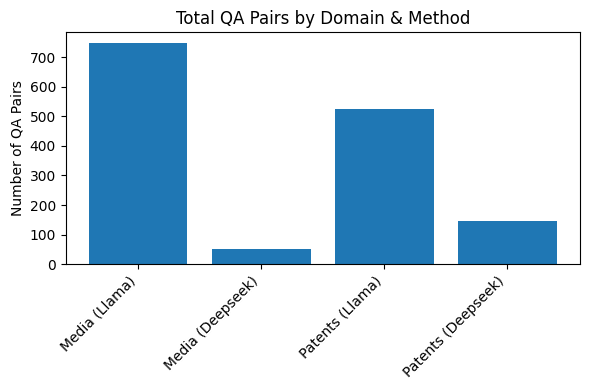

In [79]:

counts = {
    'Media (Llama)':       len(media_qa_df_llama),
    'Media (Deepseek)':    len(media_qa_df_deepseek),
    'Patents (Llama)':     len(patents_qa_df_llama),
    'Patents (Deepseek)':  len(patents_qa_df_deepseek),
}

plt.figure(figsize=(6,4))
plt.bar(counts.keys(), counts.values())
plt.title("Total QA Pairs by Domain & Method")
plt.ylabel("Number of QA Pairs")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


## 4. QA Pair Classification

After generating our QA pairs, our next step is to classify each question into a category. This categorization is essential to ensure that our QA pairs cover diverse aspects of cleantech, such as factual details, comparative market analysis, analytical explanations, government or corporate initiatives, and sustainability or technological innovations.

For each generated QA pair, we want to automatically determine the most suitable category based on the question's content. We experimented with two methods:

  -  A Rule-Based Approach:

        This method involves defining a dictionary of categories along with associated keywords. For each question, we count the occurrences of each keyword corresponding to every category. The category with the highest score is assigned to the question.
        It is easily interpretable since we can trace the category decision to keyword matches. However, it is limited flexibility if questions use synonyms or varied phrasing that is not in the keyword list.

  - BERT Sentence Approach:
    In this approach, we use a SentenceTransformer model to encode each generated question into an embedding vector. We then compare these embeddings to precomputed embeddings of category prototype texts (i.e., descriptions of what each category should capture) using cosine similarity. The category with the highest similarity score is assigned to the question.
    In this approach, Tthe quality of classification heavily depends on the choice of the prototype texts and the underlying model.
    We have evaluated both methods and found that the BERT sentence approach outperformed the rule-based method. For patent questions, we even experimented with replacing the  [all-MiniLM-L6-v2](https://huggingface.co/sentence-transformers/all-MiniLM-L6-v2) model with the [AI-Growth-Lab/PatentSBERTa](https://github.com/AI-Growth-Lab/PatentSBERTa) model, which gave even better results in capturing nuanced technical details.



In [8]:

patent_qa_df_llama = pd.read_csv("datasets/patents_qa_df_510_llama_new.csv")
media_qa_df_llama = pd.read_csv("datasets/media_qa_df_llama.csv")


In [9]:
patents_qa_df = [patent_qa_df_llama]
media_qa_df = [media_qa_df_llama]

### The rule based approach

In [10]:


def classify_question_rule_based(question, categories):
    question_lower = question.lower()
    scores = {cat: 0 for cat in categories}
    for cat, keywords in categories.items():
        for kw in keywords:
            if kw in question_lower:
                scores[cat] += 1
    return max(scores, key=scores.get)

categories = {
    "Factual Questions": ["what", "when", "where", "who", "which", "fact"],
    "Comparative & Market Analysis Questions": ["compare", "contrast", "market", "trend", "analysis"],
    "Analytical & Explanatory Questions": ["why", "how", "explain", "impact"],
    "Government & Corporate Initiatives": ["government", "policy", "corporate", "initiative", "regulation"],
    "Sustainability & Technological Innovation Questions": ["sustainable", "innovation", "technology", "renewable", "eco-friendly"]
}

def stack_and_categorize(dfs, categories):
    df_combined = pd.concat(dfs, ignore_index=True)
    df_combined['category'] = df_combined['question'].apply(lambda q: classify_question_rule_based(q, categories))
    return df_combined




In [11]:

df_patent_categorized_rule_based = stack_and_categorize(patents_qa_df, categories)
df_media_categorized_rule_based = stack_and_categorize(media_qa_df, categories)

In [13]:
df_patent_categorized_rule_based.head(3)

,question,answer,relevant_text,title,publication_date,inventor,category
0,What is the purpose of the cold accumulator evaporator?,"To supply cold to the cold storage, reducing the cost of the cold storage and saving energy.",Distributed photovoltaic energy storage refrigeration house systemThe utility model discloses a ...,Distributed photovoltaic energy storage refrigeration house system,20220405,"['ZHANG YU', 'WANG GUANGLIN']",Factual Questions
1,What is the role of the refrigeration house condenser?,It is connected with the cold accumulation compressor unit and supplies steam to it.,Distributed photovoltaic energy storage refrigeration house systemThe utility model discloses a ...,Distributed photovoltaic energy storage refrigeration house system,20220405,"['ZHANG YU', 'WANG GUANGLIN']",Factual Questions
2,What is the overall function of the distributed photovoltaic energy storage refrigeration house ...,To convert solar energy into electric energy to store ice and provide cold storage while saving ...,Distributed photovoltaic energy storage refrigeration house systemThe utility model discloses a ...,Distributed photovoltaic energy storage refrigeration house system,20220405,"['ZHANG YU', 'WANG GUANGLIN']",Factual Questions


In [14]:
df_media_categorized_rule_based.head(3)

,question,relevant_text,answer,article_url,category
0,"What is green hydrogen, and how is it produced?","As we move toward a sustainable future, green hydrogen is a significant player in the renewable ...",Green hydrogen is a sustainable energy carrier produced by water electrolysis using renewable en...,https://www.azocleantech.com/article.aspx?ArticleID=1823,Factual Questions
1,Who are some of the key players involved in the development and adoption of green hydrogen?,"As we move toward a sustainable future, green hydrogen is a significant player in the renewable ...","Key players include companies like Siemens Energy, ITM Power, and H2Pro, as well as academia and...",https://www.azocleantech.com/article.aspx?ArticleID=1823,Factual Questions
2,What are the main challenges associated with integrating green hydrogen into the energy grid?,"As we move toward a sustainable future, green hydrogen is a significant player in the renewable ...","The main challenges include technical hurdles such as lower energy efficiency, safe storage and ...",https://www.azocleantech.com/article.aspx?ArticleID=1823,Factual Questions


### The Sentence transformer approach

#### The all-MiniLM-L6-v2 approach

In [ ]:

from sentence_transformers import SentenceTransformer, util
import torch

prototypes = {
    "Factual Questions": "Questions that ask for specific facts or details.",
    "Comparative & Market Analysis Questions": "Questions that compare options or analyze market trends.",
    "Analytical & Explanatory Questions": "Questions that require detailed analysis or explanation.",
    "Government & Corporate Initiatives": "Questions related to government policies or corporate initiatives.",
    "Sustainability & Technological Innovation Questions": "Questions focusing on sustainability and innovative technology."
}

model = SentenceTransformer('all-MiniLM-L6-v2')

prototype_texts = list(prototypes.values())
prototype_labels = list(prototypes.keys())
prototype_embeddings = model.encode(prototype_texts, convert_to_tensor=True)

def classify_question_embedding(question: str) -> str:
    """
    Classify a question into one of the five categories using cosine similarity
    between its embedding and the precomputed prototype embeddings.
    """
    question_embedding = model.encode(question, convert_to_tensor=True)
    cosine_scores = util.cos_sim(question_embedding, prototype_embeddings)
    best_idx = torch.argmax(cosine_scores).item()
    return prototype_labels[best_idx]

def stack_and_categorize(dfs: list) -> pd.DataFrame:
    """
    Stack multiple DataFrames and add a new 'category' column by classifying each question.
    """
    df_combined = pd.concat(dfs, ignore_index=True)
    df_combined['category'] = df_combined['question'].apply(lambda q: classify_question_embedding(q))
    return df_combined



In [16]:
df_patent_categorized_sentence_bert = stack_and_categorize(patents_qa_df)
df_media_categorized_sentence_bert = stack_and_categorize(media_qa_df)

In [17]:
df_patent_categorized_sentence_bert.head(3)

,question,answer,relevant_text,title,publication_date,inventor,category
0,What is the purpose of the cold accumulator evaporator?,"To supply cold to the cold storage, reducing the cost of the cold storage and saving energy.",Distributed photovoltaic energy storage refrigeration house systemThe utility model discloses a ...,Distributed photovoltaic energy storage refrigeration house system,20220405,"['ZHANG YU', 'WANG GUANGLIN']",Analytical & Explanatory Questions
1,What is the role of the refrigeration house condenser?,It is connected with the cold accumulation compressor unit and supplies steam to it.,Distributed photovoltaic energy storage refrigeration house systemThe utility model discloses a ...,Distributed photovoltaic energy storage refrigeration house system,20220405,"['ZHANG YU', 'WANG GUANGLIN']",Government & Corporate Initiatives
2,What is the overall function of the distributed photovoltaic energy storage refrigeration house ...,To convert solar energy into electric energy to store ice and provide cold storage while saving ...,Distributed photovoltaic energy storage refrigeration house systemThe utility model discloses a ...,Distributed photovoltaic energy storage refrigeration house system,20220405,"['ZHANG YU', 'WANG GUANGLIN']",Sustainability & Technological Innovation Questions


In [18]:
df_media_categorized_sentence_bert.head(3)

,question,relevant_text,answer,article_url,category
0,"What is green hydrogen, and how is it produced?","As we move toward a sustainable future, green hydrogen is a significant player in the renewable ...",Green hydrogen is a sustainable energy carrier produced by water electrolysis using renewable en...,https://www.azocleantech.com/article.aspx?ArticleID=1823,Sustainability & Technological Innovation Questions
1,Who are some of the key players involved in the development and adoption of green hydrogen?,"As we move toward a sustainable future, green hydrogen is a significant player in the renewable ...","Key players include companies like Siemens Energy, ITM Power, and H2Pro, as well as academia and...",https://www.azocleantech.com/article.aspx?ArticleID=1823,Sustainability & Technological Innovation Questions
2,What are the main challenges associated with integrating green hydrogen into the energy grid?,"As we move toward a sustainable future, green hydrogen is a significant player in the renewable ...","The main challenges include technical hurdles such as lower energy efficiency, safe storage and ...",https://www.azocleantech.com/article.aspx?ArticleID=1823,Sustainability & Technological Innovation Questions


#### The AI-Growth-Lab/PatentSBERTa approach

In [ ]:

model = SentenceTransformer('AI-Growth-Lab/PatentSBERTa')

prototype_texts = list(prototypes.values())
prototype_labels = list(prototypes.keys())
prototype_embeddings = model.encode(prototype_texts, convert_to_tensor=True)



In [20]:
df_patent_categorized_patent_sentence_bert = stack_and_categorize(patents_qa_df)
df_media_categorized_patent_sentence_bert= stack_and_categorize(media_qa_df)



In [23]:
df_patent_categorized_patent_sentence_bert.head(3)

,question,answer,relevant_text,title,publication_date,inventor,category
0,What is the purpose of the cold accumulator evaporator?,"To supply cold to the cold storage, reducing the cost of the cold storage and saving energy.",Distributed photovoltaic energy storage refrigeration house systemThe utility model discloses a ...,Distributed photovoltaic energy storage refrigeration house system,20220405,"['ZHANG YU', 'WANG GUANGLIN']",Analytical & Explanatory Questions
1,What is the role of the refrigeration house condenser?,It is connected with the cold accumulation compressor unit and supplies steam to it.,Distributed photovoltaic energy storage refrigeration house systemThe utility model discloses a ...,Distributed photovoltaic energy storage refrigeration house system,20220405,"['ZHANG YU', 'WANG GUANGLIN']",Analytical & Explanatory Questions
2,What is the overall function of the distributed photovoltaic energy storage refrigeration house ...,To convert solar energy into electric energy to store ice and provide cold storage while saving ...,Distributed photovoltaic energy storage refrigeration house systemThe utility model discloses a ...,Distributed photovoltaic energy storage refrigeration house system,20220405,"['ZHANG YU', 'WANG GUANGLIN']",Sustainability & Technological Innovation Questions


In [24]:
df_media_categorized_patent_sentence_bert.head(3)

,question,relevant_text,answer,article_url,category
0,"What is green hydrogen, and how is it produced?","As we move toward a sustainable future, green hydrogen is a significant player in the renewable ...",Green hydrogen is a sustainable energy carrier produced by water electrolysis using renewable en...,https://www.azocleantech.com/article.aspx?ArticleID=1823,Sustainability & Technological Innovation Questions
1,Who are some of the key players involved in the development and adoption of green hydrogen?,"As we move toward a sustainable future, green hydrogen is a significant player in the renewable ...","Key players include companies like Siemens Energy, ITM Power, and H2Pro, as well as academia and...",https://www.azocleantech.com/article.aspx?ArticleID=1823,Sustainability & Technological Innovation Questions
2,What are the main challenges associated with integrating green hydrogen into the energy grid?,"As we move toward a sustainable future, green hydrogen is a significant player in the renewable ...","The main challenges include technical hurdles such as lower energy efficiency, safe storage and ...",https://www.azocleantech.com/article.aspx?ArticleID=1823,Sustainability & Technological Innovation Questions


### Visualizing and Comparing Classification Approaches

After classifying our QA pairs, we plotted the number of questions in each category to evaluate how well each approach captured the variety of question types.

  1. Rule-Based Approach
  The rule-based approach appears biased toward Factual Questions because it heavily relies on keyword matching. When questions do not contain the keywords associated with the other categories, they are often labeled as factual by default.

  2. BERT Sentence Approach
  The BERT based semantic classification captures more nuance and distributes questions more evenly across multiple categories. It identifies many questions about sustainability and technological innovation highlighting how semantic embeddings can detect relevant context even if explicit keywords are missing.

  3. Patent-Specific BERT Model (PatentSBERTa)
  Because PatentSBERTa is fine-tuned for patent text, it performs even better at placing technical questions into the correct categories. This is especially important for recognizing subtle phrases and context in patent abstracts.


We decided to go with the Bert approach for classifying all QA pairs, ensuring more nuanced and reliable coverage of the different cleantech question types.

In [25]:
categories_rule_based = df_patent_categorized_rule_based['category'].value_counts()


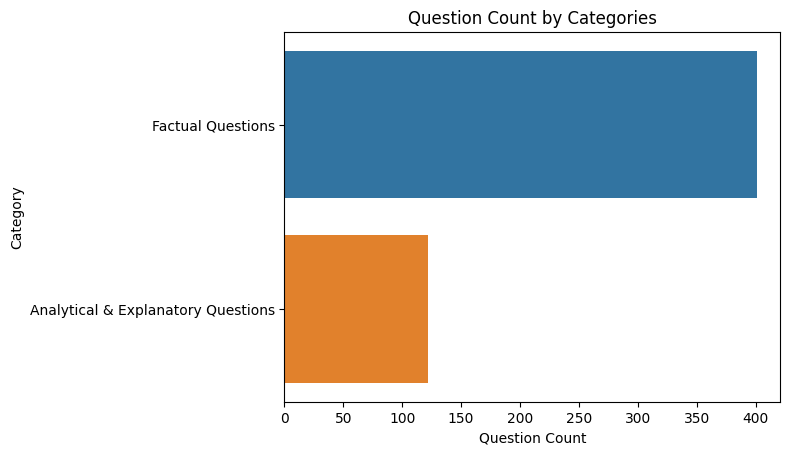

In [26]:
barplot = sns.barplot(
    x=categories_rule_based.values,
    y=categories_rule_based.index,
    hue=categories_rule_based.index
)

barplot.set_title('Question Count by Categories')
barplot.set_xlabel('Question Count')
barplot.set_ylabel('Category')

plt.show()

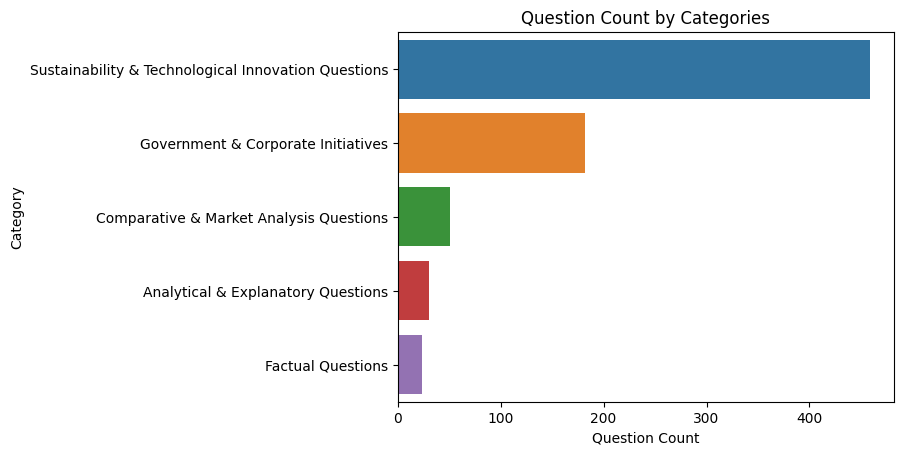

In [27]:
categories_sentence_bert = df_media_categorized_sentence_bert['category'].value_counts()

barplot = sns.barplot(
    x=categories_sentence_bert.values,
    y=categories_sentence_bert.index,
    hue=categories_sentence_bert.index
)

barplot.set_title('Question Count by Categories')
barplot.set_xlabel('Question Count')
barplot.set_ylabel('Category')

plt.show()

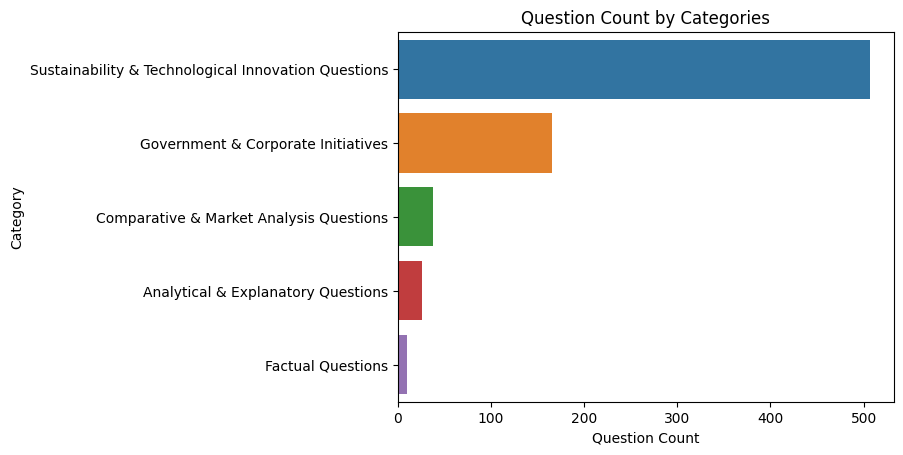

In [28]:
categories_patent_bert = df_media_categorized_patent_sentence_bert['category'].value_counts()

barplot = sns.barplot(
    x=categories_patent_bert.values,
    y=categories_patent_bert.index,
    hue=categories_patent_bert.index
)

barplot.set_title('Question Count by Categories')
barplot.set_xlabel('Question Count')
barplot.set_ylabel('Category')

plt.show()

## The QAs pairs are divided in these questions categories:

- Factual Questions

- Comparative & Market Analysis Questions

- Analytical & Explanatory Questions

- Government & Corporate Initiatives

- Sustainability & Technological Innovation Questions



### Factual Questions

Factual Questions: Ask for concrete details or definitions (e.g., “What is…”).

In [29]:
factual_questions = df_media_categorized_sentence_bert [df_media_categorized_sentence_bert ['category'] == 'Factual Questions']['question'].tolist()
factual_df = df_media_categorized_sentence_bert [df_media_categorized_sentence_bert ['category'] == 'Factual Questions']


In [32]:
show_questions("Factual Questions for the Media Dataset", factual_questions)


Factual Questions for the Media Dataset
---------------------------------------
1. How long will your questions, but not your email details, be shared with OpenAI?
2. What is the Hudson Bay located in?
3. How many polar bears are estimated to reside in the Hudson Bay?
4. Why is sea ice important for polar bears in the Hudson Bay?
5. What is the current ice-free period in the Hudson Bay?
6. What is the maximum fasting time that adult polar bears can tolerate?



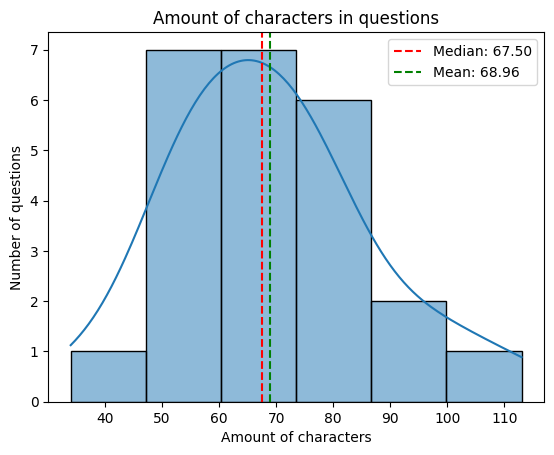

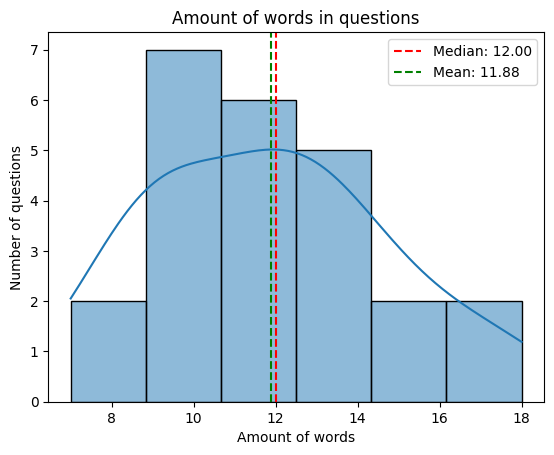

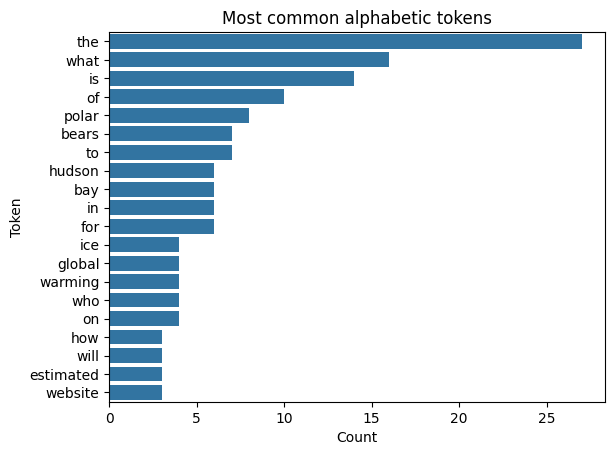

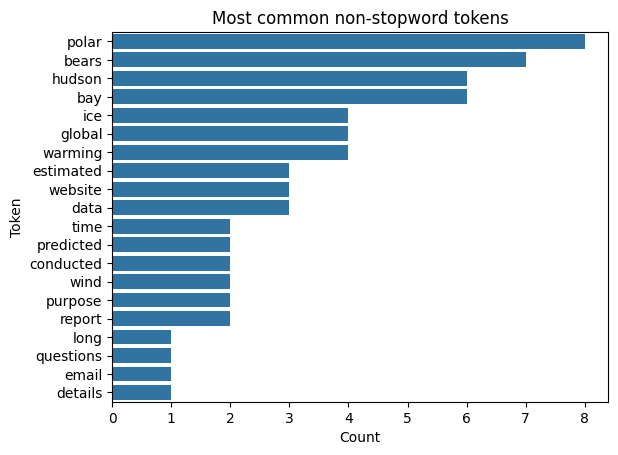

In [33]:
plot_character_distribution(factual_df)
plot_word_distribution(factual_df)
plot_gpt4_token_distribution(factual_df)
plot_non_stopword_token_distribution(factual_df)

Factual Questions
-----------------
1. What is the purpose of the tower heliostat?
2. What is the role of the tower type heliostat in the system?
3. What kind of data do we need to acquire to balance electric quantity in a power system containing large-scale renewable energy sources?
4. What system does the device utilize for control and temperature setting?
5. How does the system get power supply?
6. What is the key component of the cable core that ensures symmetry between the main wire core and the ground wire core?



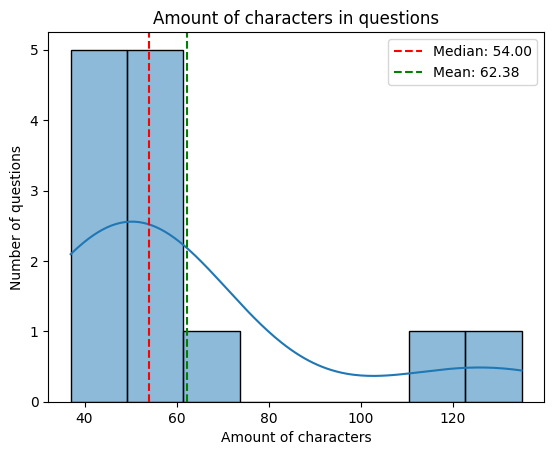

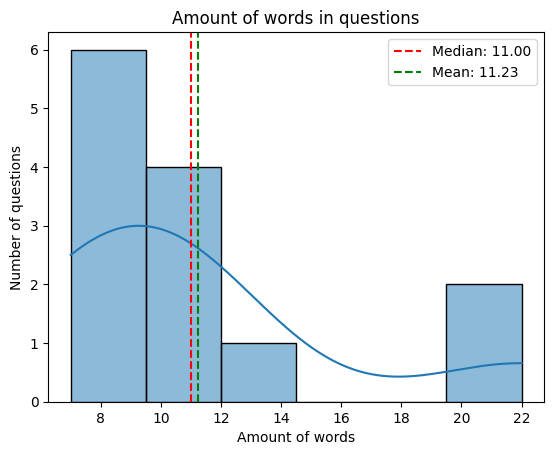

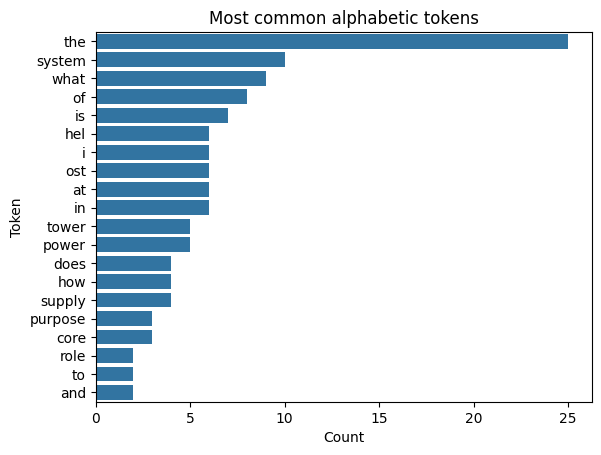

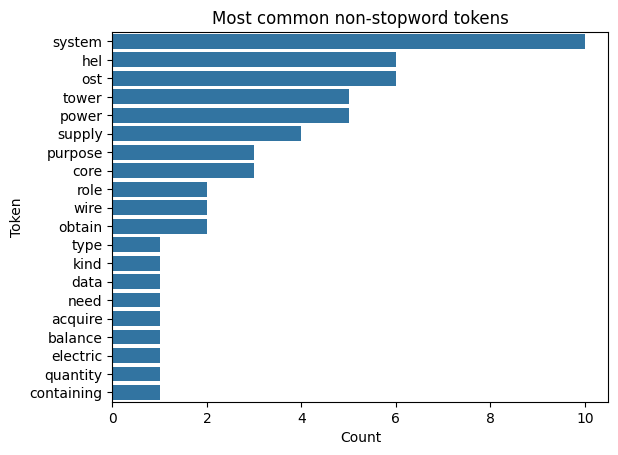

In [ ]:
factual_questions = df_patent_categorized_sentence_bert  [df_patent_categorized_sentence_bert  ['category'] == 'Factual Questions']['question'].tolist()
factual_df = df_patent_categorized_sentence_bert  [df_patent_categorized_sentence_bert  ['category'] == 'Factual Questions']
show_questions("Factual Questions for the Patent Dataset", factual_questions)
plot_character_distribution(factual_df)
plot_word_distribution(factual_df)
plot_gpt4_token_distribution(factual_df)
plot_non_stopword_token_distribution(factual_df)

### Comparative & Market Analysis Questions

Involve comparing cleantech technologies or approaches (e.g., “What are the differences between…”).

In [35]:
Comparative_Market_Analysis_Questions = df_media_categorized_sentence_bert [df_media_categorized_sentence_bert ['category'] == 'Comparative & Market Analysis Questions']['question'].tolist()
Comparative_Market_Analysis_df = df_media_categorized_sentence_bert [df_media_categorized_sentence_bert ['category'] == 'Comparative & Market Analysis Questions']


In [36]:
show_questions("Comparative & Market Analysis Questions for the Media Dataset", Comparative_Market_Analysis_Questions)


Comparative & Market Analysis Questions for the Media Dataset
-------------------------------------------------------------
1. What is the estimated total sales volume target for Asahi Kasei's hydrogen business by 2030?
2. How has the Hudson Bay area warmed over the last three decades?
3. Who will lead GRNE after the acquisition?
4. How does GRNE plan to continue growing after the acquisition?
5. Who has expressed excitement about the acquisition?
6. Where are large solar markets more prone to extreme weather-related damage?



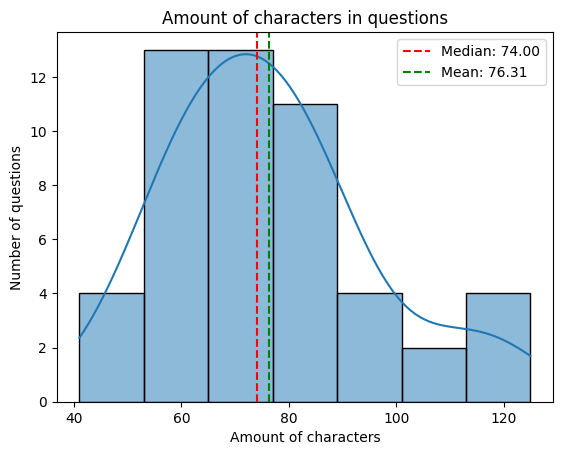

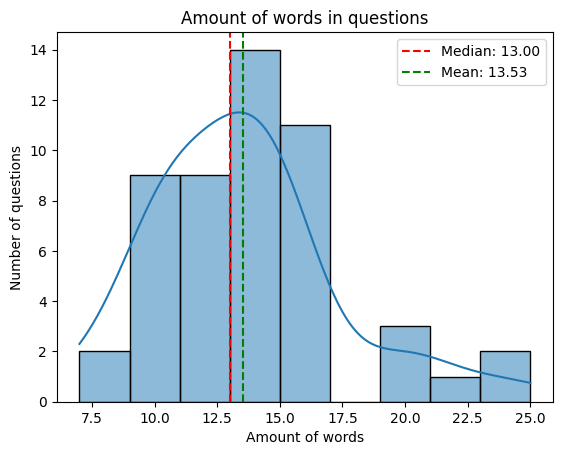

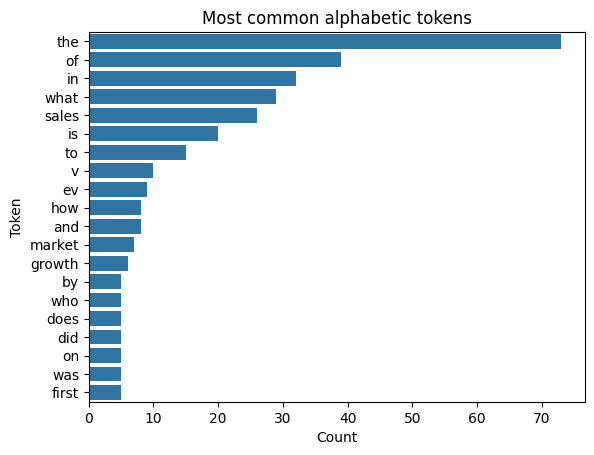

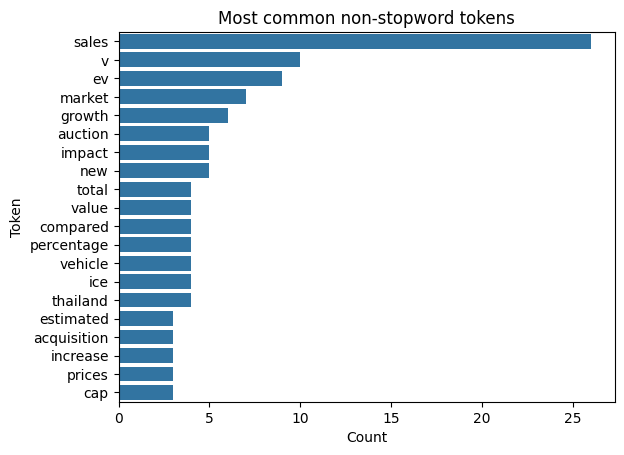

In [37]:
plot_character_distribution(Comparative_Market_Analysis_df)
plot_word_distribution(Comparative_Market_Analysis_df)
plot_gpt4_token_distribution(Comparative_Market_Analysis_df)
plot_non_stopword_token_distribution(Comparative_Market_Analysis_df)

Comparative & Market Analysis Questions for the Patent Dataset
--------------------------------------------------------------
1. question
2. answer
3. relevant_text
4. title
5. publication_date
6. inventor
7. category



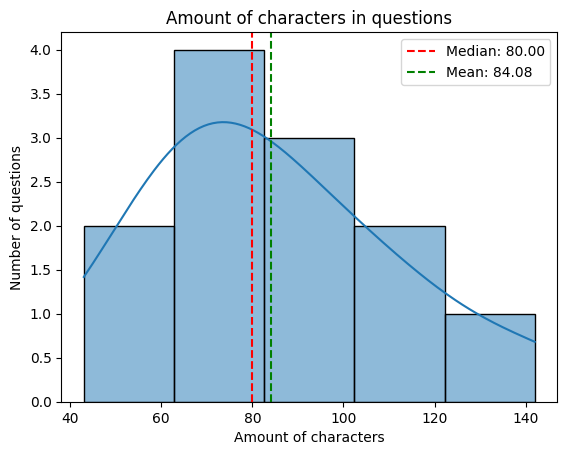

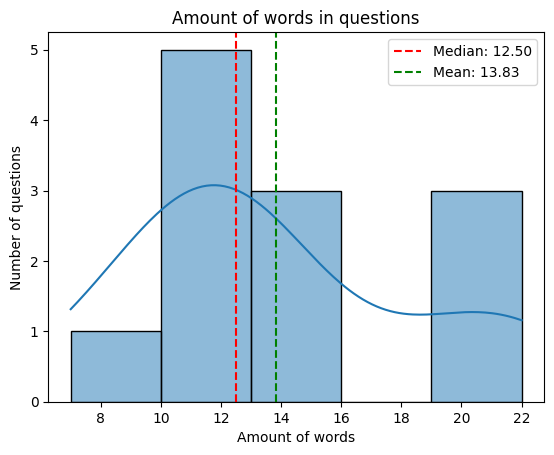

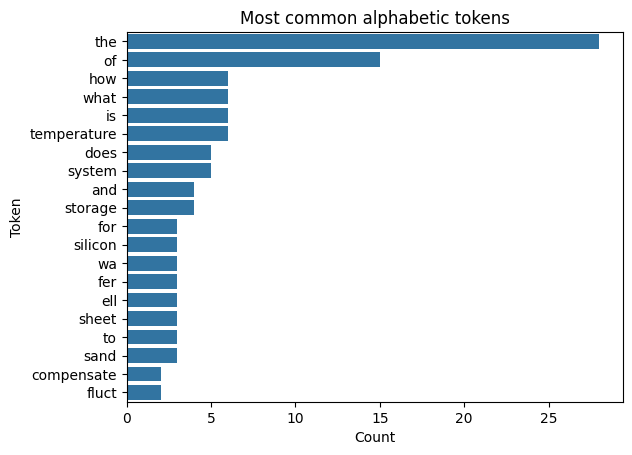

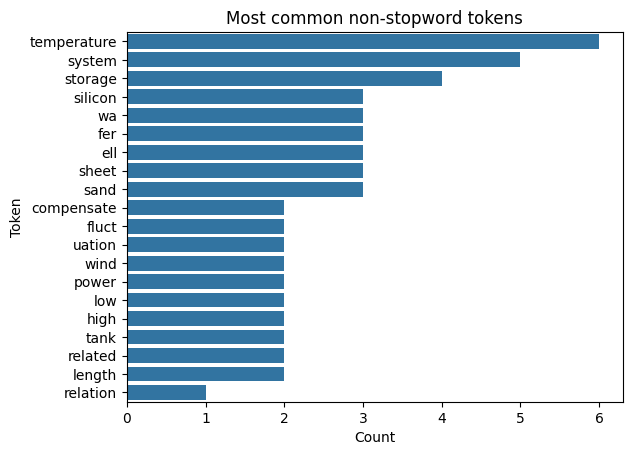

In [38]:
Comparative_Market_Analysis_Questions = df_patent_categorized_sentence_bert  [df_patent_categorized_sentence_bert  ['category'] == 'Comparative & Market Analysis Questions']['question'].tolist()
Comparative_Market_Analysis_df = df_patent_categorized_sentence_bert  [df_patent_categorized_sentence_bert  ['category'] == 'Comparative & Market Analysis Questions']
show_questions("Comparative & Market Analysis Questions for the Patent Dataset", Comparative_Market_Analysis_df)
plot_character_distribution(Comparative_Market_Analysis_df)
plot_word_distribution(Comparative_Market_Analysis_df)
plot_gpt4_token_distribution(Comparative_Market_Analysis_df)
plot_non_stopword_token_distribution(Comparative_Market_Analysis_df)

### Analytical & Explanatory Questions

equire reasoning or explanation (e.g., “How does…”).

In [39]:
Analytical_Explanatory_Questions = df_media_categorized_sentence_bert [df_media_categorized_sentence_bert ['category'] == 'Analytical & Explanatory Questions']['question'].tolist()
Analytical_Explanatory_Questions_df = df_media_categorized_sentence_bert [df_media_categorized_sentence_bert ['category'] == 'Analytical & Explanatory Questions']

In [40]:
show_questions("Analytical & Explanatory Questions for the Media Dataset", Analytical_Explanatory_Questions)


Analytical & Explanatory Questions for the Media Dataset
--------------------------------------------------------
1. What is the need for robust safety protocols and storage solutions for hydrogen due to its highly flammable nature?
2. Where did Julienne Stroeve and colleagues estimate projected changes to the ice-free time?
3. What technique is used to separate batteries' cathodes and anodes?
4. What is the role of the EverBatt model in the research project?
5. What type of testing is being done by researchers at MERF?
6. What is the limitation of the current study, according to the researchers?



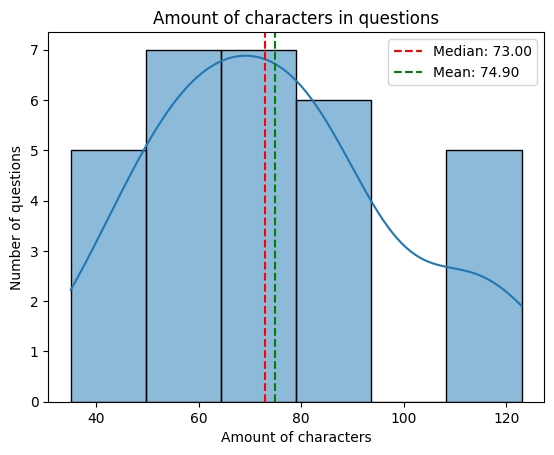

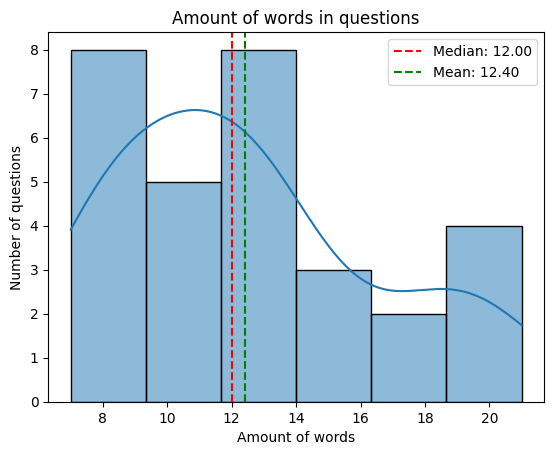

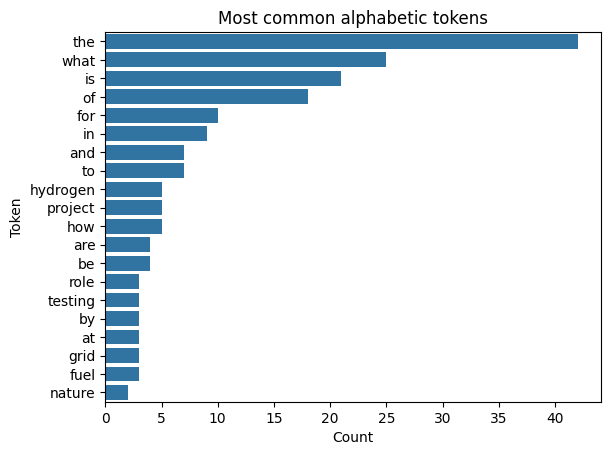

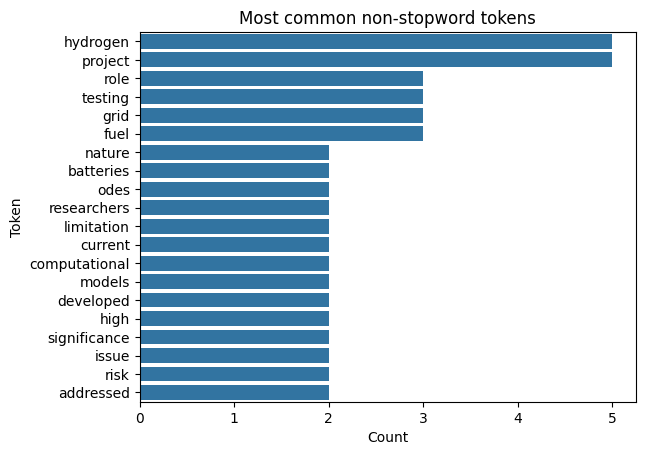

In [41]:
plot_character_distribution(Analytical_Explanatory_Questions_df)
plot_word_distribution(Analytical_Explanatory_Questions_df)
plot_gpt4_token_distribution(Analytical_Explanatory_Questions_df)
plot_non_stopword_token_distribution(Analytical_Explanatory_Questions_df)

Analytical & Explanatory Questions for the Patent Dataset
---------------------------------------------------------
1. What is the purpose of the cold accumulator evaporator?
2. What is the purpose of the utility model?
3. What makes the structure easy to handle?
4. What is the main challenge that the utility model solves?
5. What is good about the utility model?
6. What is facilitated by the utility model?



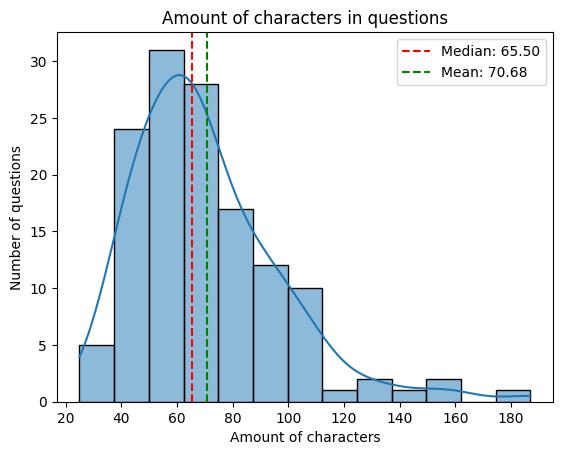

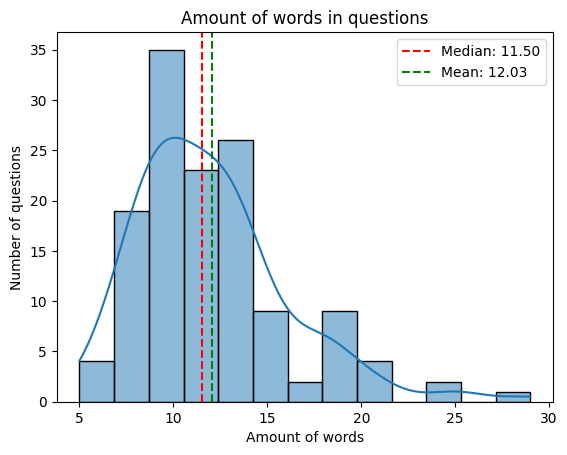

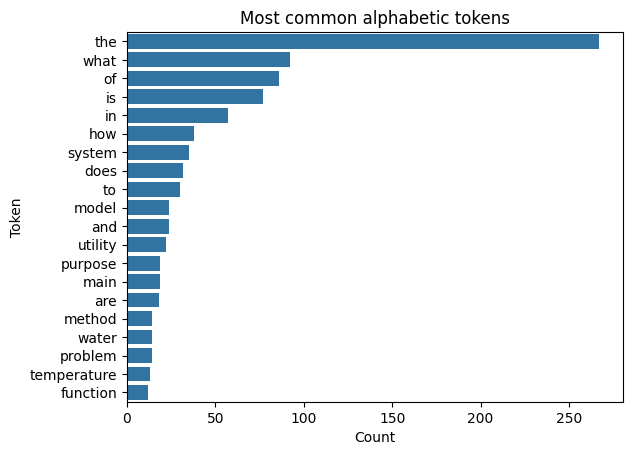

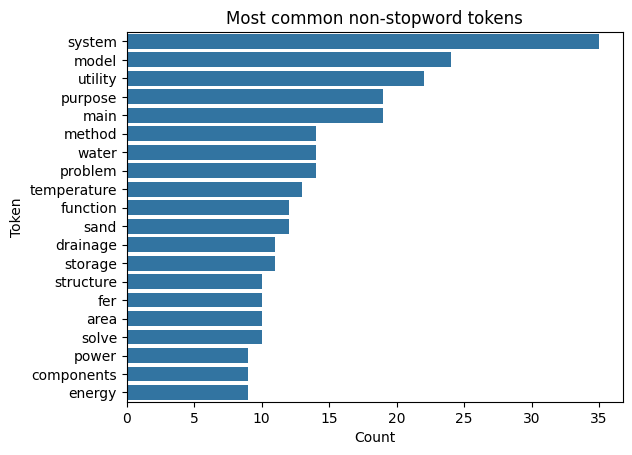

In [42]:
Analytical_Explanatory_Questions = df_patent_categorized_sentence_bert [df_patent_categorized_sentence_bert ['category'] == 'Analytical & Explanatory Questions']['question'].tolist()
Analytical_Explanatory_Questions_df = df_patent_categorized_sentence_bert [df_patent_categorized_sentence_bert ['category'] == 'Analytical & Explanatory Questions']
show_questions("Analytical & Explanatory Questions for the Patent Dataset", Analytical_Explanatory_Questions)
plot_character_distribution(Analytical_Explanatory_Questions_df)
plot_word_distribution(Analytical_Explanatory_Questions_df)
plot_gpt4_token_distribution(Analytical_Explanatory_Questions_df)
plot_non_stopword_token_distribution(Analytical_Explanatory_Questions_df)



### Government & Corporate Initiatives

In [43]:
Government_Corporate_Initiatives = df_media_categorized_sentence_bert [df_media_categorized_sentence_bert ['category'] == 'Government & Corporate Initiatives']['question'].tolist()
Government_Corporate_Initiatives_df = df_media_categorized_sentence_bert [df_media_categorized_sentence_bert ['category'] == 'Government & Corporate Initiatives']

In [44]:
show_questions("Government & Corporate Initiatives for the Media Dataset", Government_Corporate_Initiatives)


Government & Corporate Initiatives for the Media Dataset
--------------------------------------------------------
1. How does the Hydrogen Council facilitate partnerships and collaboration among companies, governments, and academia?
2. What is the role of international cooperation in promoting green hydrogen adoption and harmonizing regulations?
3. When did the company start operation on its commercial-scale facility in Kawasaki, Japan?
4. Who is the Lead Executive Officer of Asahi Kasei responsible for the company's hydrogen business?
5. What is the name of the company discussed in the interview?
6. Who is behind the collaboration between the US Department of Energy's Argonne National Laboratory and Toyota Motor North America?



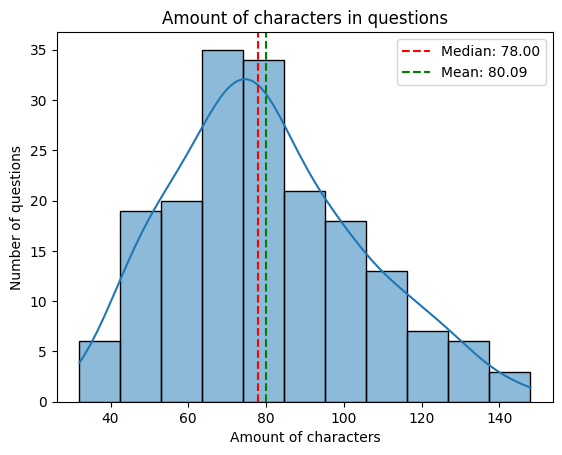

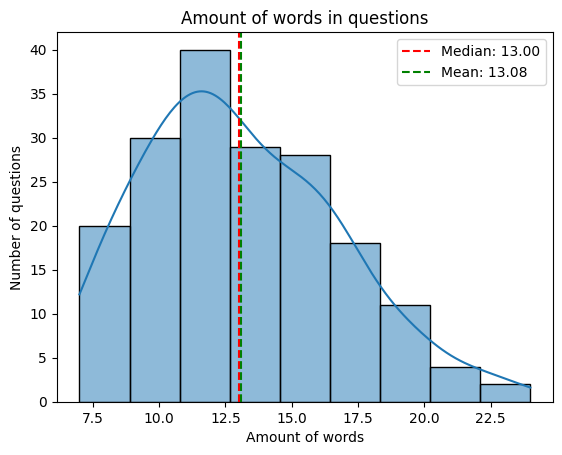

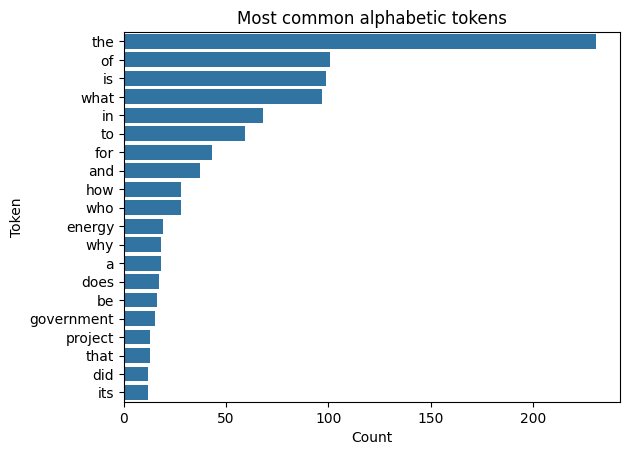

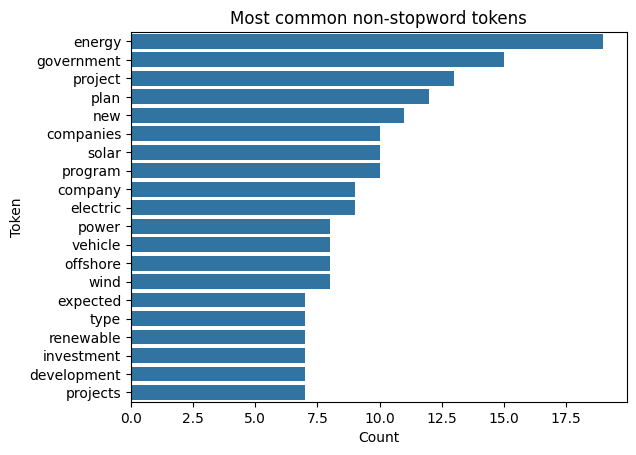

In [45]:
plot_character_distribution(Government_Corporate_Initiatives_df)
plot_word_distribution(Government_Corporate_Initiatives_df)
plot_gpt4_token_distribution(Government_Corporate_Initiatives_df)
plot_non_stopword_token_distribution(Government_Corporate_Initiatives_df)

Government & Corporate Initiatives for the Patent Dataset
---------------------------------------------------------
1. What is the role of the refrigeration house condenser?
2. What are the main components of the cable core?
3. What type of insulation is used on the main wire core?
4. What are the three key components of the cable core in the insulation low-smoke halogen-free torsion-resistant medium-voltage wind energy cable?
5. How is the main wire core formed during the manufacturing process?
6. What is the arrangement of the main wire core, ground wire core, ethylene propylene fillings, and semi-conductive filling in the cable core?



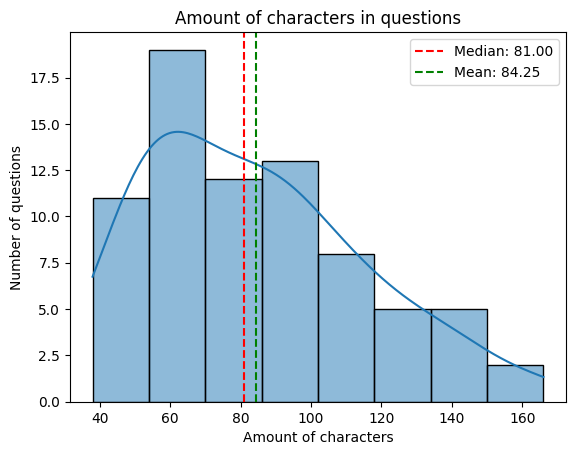

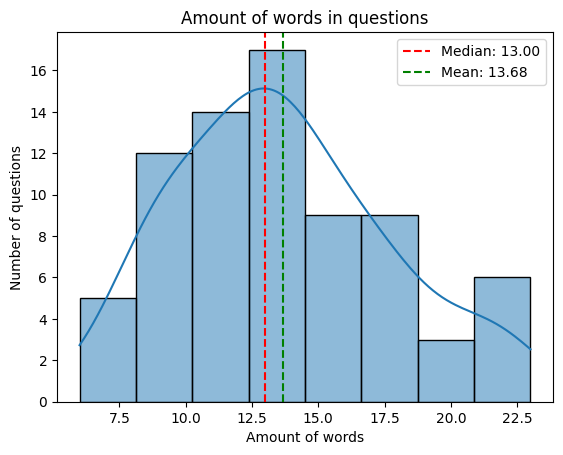

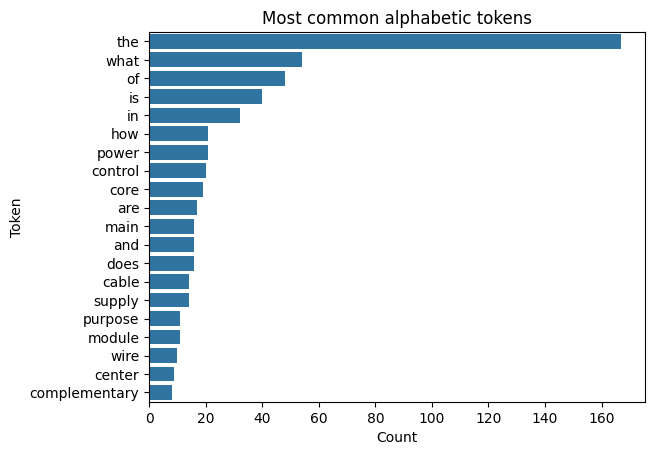

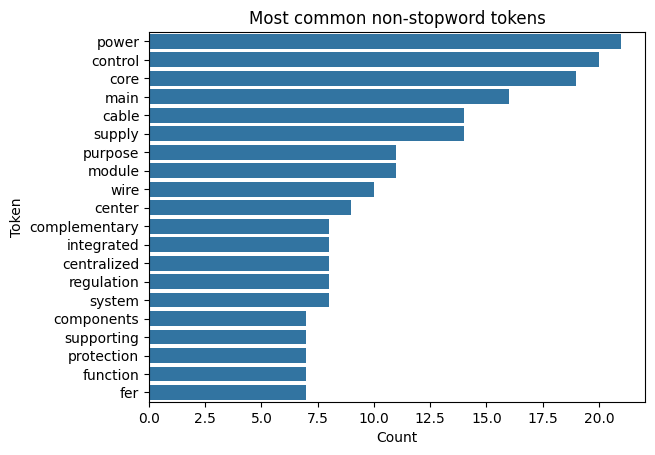

In [46]:
Government_Corporate_Initiatives = df_patent_categorized_sentence_bert [df_patent_categorized_sentence_bert ['category'] == 'Government & Corporate Initiatives']['question'].tolist()
Government_Corporate_Initiatives_df = df_patent_categorized_sentence_bert [df_patent_categorized_sentence_bert ['category'] == 'Government & Corporate Initiatives']
show_questions("Government & Corporate Initiatives for the Patent Dataset", Government_Corporate_Initiatives)
plot_character_distribution(Government_Corporate_Initiatives_df)
plot_word_distribution(Government_Corporate_Initiatives_df)
plot_gpt4_token_distribution(Government_Corporate_Initiatives_df)
plot_non_stopword_token_distribution(Government_Corporate_Initiatives_df)

### Sustainability & Technological Innovation Questions

In [47]:
Sustainability_Technological_Innovation_Questions = df_media_categorized_sentence_bert [df_media_categorized_sentence_bert ['category'] == 'Sustainability & Technological Innovation Questions']['question'].tolist()
Sustainability_Technological_Innovation_Questions_df = df_media_categorized_sentence_bert [df_media_categorized_sentence_bert ['category'] == 'Sustainability & Technological Innovation Questions']

In [48]:
show_questions("Sustainability & Technological Innovation Questions for the Media Dataset", Sustainability_Technological_Innovation_Questions)


Sustainability & Technological Innovation Questions for the Media Dataset
-------------------------------------------------------------------------
1. What is green hydrogen, and how is it produced?
2. Who are some of the key players involved in the development and adoption of green hydrogen?
3. What are the main challenges associated with integrating green hydrogen into the energy grid?
4. What is the role of the European Union's Hydrogen Strategy in promoting green hydrogen adoption?
5. What is the significance of the Neom project in Saudi Arabia as a pioneering example of green hydrogen integration?
6. What is the goal of the HyGreen Provence Project in France, and how does it contribute to regional energy transition efforts?



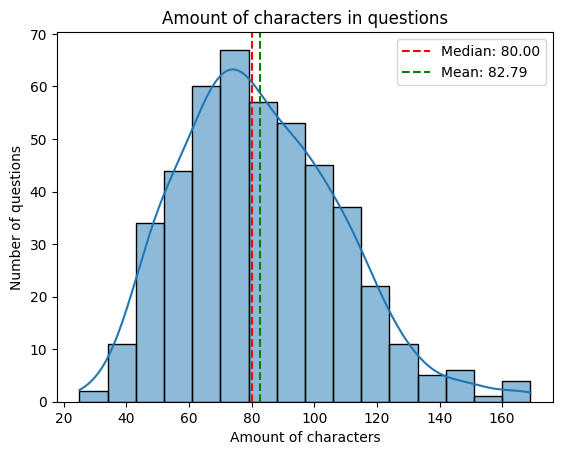

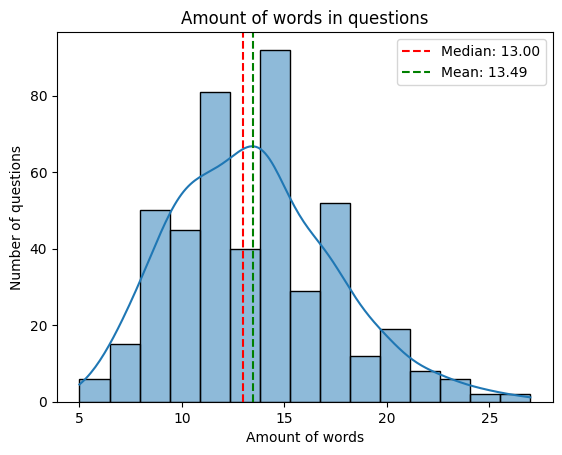

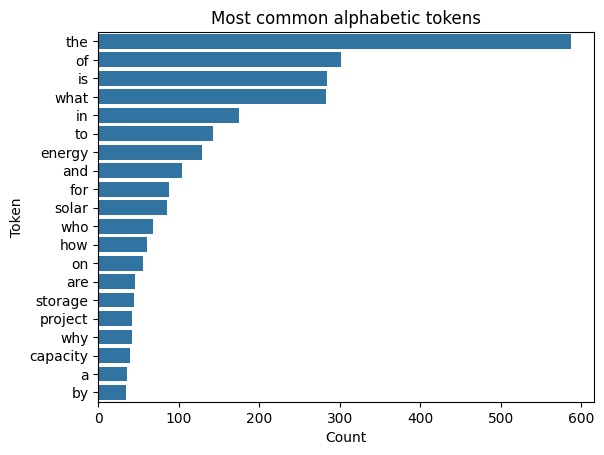

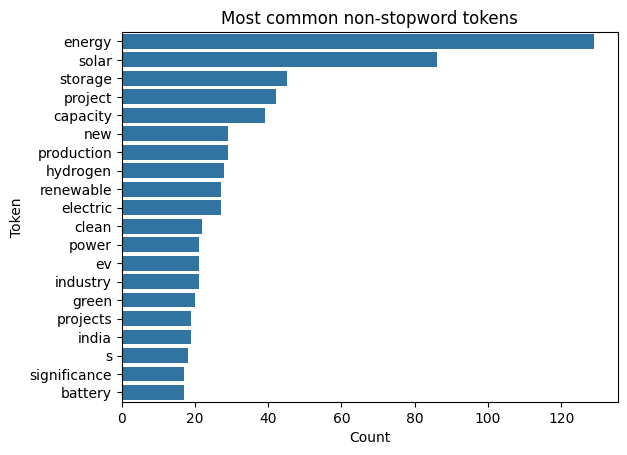

In [49]:
plot_character_distribution(Sustainability_Technological_Innovation_Questions_df)
plot_word_distribution(Sustainability_Technological_Innovation_Questions_df)
plot_gpt4_token_distribution(Sustainability_Technological_Innovation_Questions_df)
plot_non_stopword_token_distribution(Sustainability_Technological_Innovation_Questions_df)

Sustainability & Technological Innovation Questions for the Patent Dataset
--------------------------------------------------------------------------
1. What is the overall function of the distributed photovoltaic energy storage refrigeration house system?
2. What is the purpose of the distributed photovoltaic energy storage refrigeration house system?
3. What is the main function of the cold accumulation equipment?
4. How does the system reduce the cost of cold storage?
5. What is unique about the mounting panel?
6. What is the purpose of the second isolation layer?



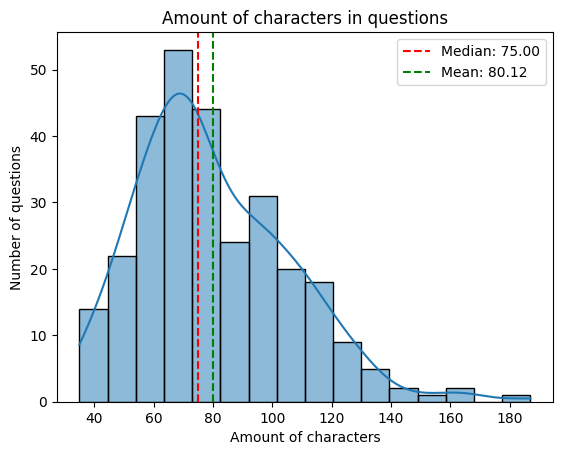

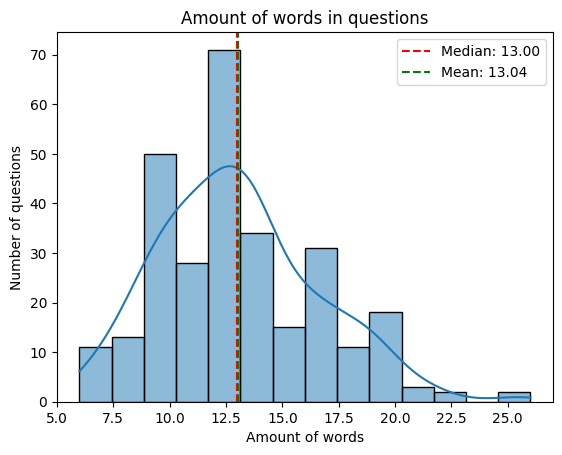

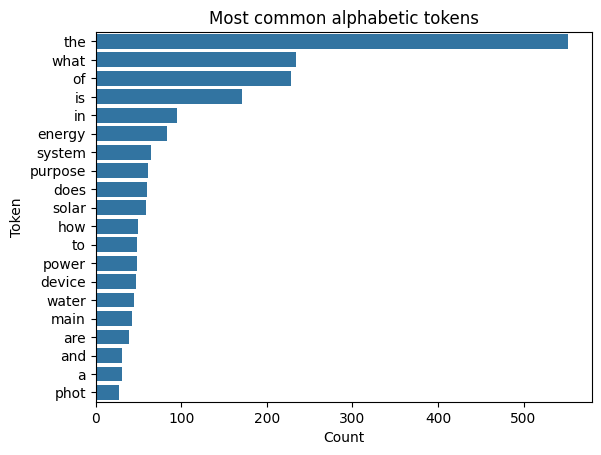

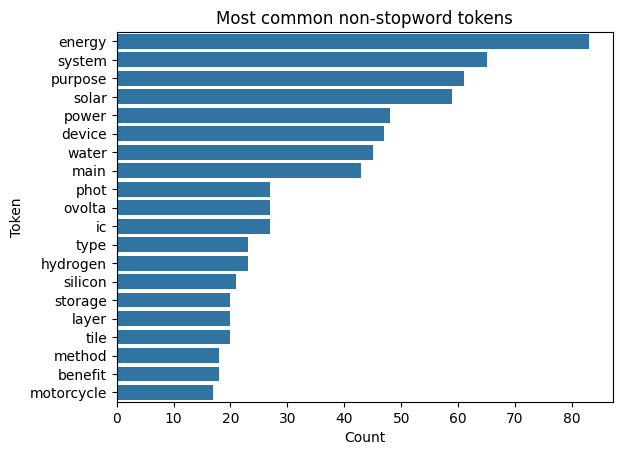

In [50]:
Sustainability_Technological_Innovation_Questions = df_patent_categorized_sentence_bert [df_patent_categorized_sentence_bert ['category'] == 'Sustainability & Technological Innovation Questions']['question'].tolist()
Sustainability_Technological_Innovation_Questions_df = df_patent_categorized_sentence_bert [df_patent_categorized_sentence_bert ['category'] == 'Sustainability & Technological Innovation Questions']
show_questions("Sustainability & Technological Innovation Questions for the Patent Dataset", Sustainability_Technological_Innovation_Questions)
plot_character_distribution(Sustainability_Technological_Innovation_Questions_df)
plot_word_distribution(Sustainability_Technological_Innovation_Questions_df)
plot_gpt4_token_distribution(Sustainability_Technological_Innovation_Questions_df)
plot_non_stopword_token_distribution(Sustainability_Technological_Innovation_Questions_df)

## 5. Setup critique agents

The questions generated by our LLM may exhibit various flaws. For instance, some questions might lack sufficient context to be answered accurately, and others may depend too much on the original document context, making them unclear when viewed in isolation.

To address this, we build critique agents—automated evaluators that rate each QA pair on three key criteria:

  - Groundedness:
  Can the question be answered unambiguously given the provided context?

  - Relevance:
  Is the question useful to machine learning developers building NLP applications?
  (For example, a question like “What is the date when transformers 4.29.1 was released?” is not very relevant.)

  - Standalone Clarity:
  Does the question make sense on its own without requiring additional context?
  (A question that refers implicitly to a specific setting without clarification would score poorly here.)

These criteria are inspired by the evaluation methods described in this [paper](https://arxiv.org/abs/2312.10003). To obtain a reliable judgment, we prompt the LLM with instructions that ask for not only a numerical score (on a scale from 1 to 5) but also a detailed rationale for that score. Providing the rationale helps verify the scoring process and gives the model additional tokens to “think” about the answer before summarizing it.

Below is the code that sets up the critique agents and applies them to our generated QA pairs.

In [51]:

patent_qa_df_llama = pd.read_csv("datasets/QA_pairs_categorized_patent_qa_df_llama.csv")
media_qa_df_llama = pd.read_csv("datasets/QA_pairs_categorized_media_qa_df_llama.csv")

In [52]:

media_qa_deepseek = pd.read_csv("datasets/QA_pairs_categorized_media_qa_df_deepseek.csv")
patent_qa_deepseek = pd.read_csv("datasets/QA_pairs_categorized_paten_qa_df_deepseek.csv")

### Converting QA Pairs into LangChain Documents & Standardized Outputs

To plug our QA pairs into LangChain and downstream RAG components, we define three helpers:

1. **`generate_langchain_document_list(df, name=None)`**  
   Transforms each QA row into a `LangchainDocument` with:  
   - `page_content` set to the QA’s `relevant_text`  
   - `metadata` containing the question, answer, category, title, and source URL  

2. **`generate_output_list(df, name=None)`**  
   Creates plain dictionaries for each QA pair, renaming keys to match RAG API expectations:  
   - For **media**: maps `relevant_text→context`, `article_url→source_doc`, plus `question`, `answer`, and `category`.  
   - For **patents**: omits `source_doc` and retains `context`, `question`, `answer`, and `category`.

3. **`remove_duplicates(outputs)`**  
   Ensures each (context, question) pair is unique by filtering out any repeated combinations, preserving only the first occurrence.


In [54]:
# convert the df to langchain document
def generate_langchain_document_list(df, name=None):
    """
    Generates a list of LangchainDocument objects from a DataFrame.

    Parameters:
        df (pd.DataFrame): DataFrame containing the data.
        name (str, optional): An optional parameter for conditional adjustments.

    Returns:
        list: A list of LangchainDocument objects.
    """
    records = df.to_dict("records")
    documents = [
        LangchainDocument(
            page_content=row["relevant_text"],
            metadata={
                "question": row["question"],
                "answer": row["answer"],
                "category": row["category"],
                "title": row["title"],
                "url": row["article_url"],
            }
        )
        for row in records
    ]
    return documents


In [55]:
def generate_output_list(df, name=None):
    records = df.to_dict("records")

    if name == "patent":
        key_mapping = {
            "relevant_text": "context",
            "question": "question",
            "answer": "answer",
            "category": "category"
        }
    else:
        key_mapping = {
            "relevant_text": "context",
            "question": "question",
            "answer": "answer",
            "article_url": "source_doc",
            "category": "category"
        }

    output_list = [
        { new_key: row[old_key] for old_key, new_key in key_mapping.items() }
        for row in records
    ]

    return output_list


In [56]:
def remove_dublicates(outputs):
  seen_content = {}
  unique_outputs = []
  for doc in outputs:
      content_question_pair = (doc['context'], doc['question'])
      # content_question_pair = (doc.page_content, doc.metadata['question'])
      if content_question_pair not in seen_content:
                seen_content[content_question_pair] = True
                unique_outputs.append(doc)

  return unique_outputs



### For the 2 llama datasets convert the output to a langchain compatible output

#### For the Media Dataset

In [58]:

media_qa_llama = [
  media_qa_df_llama
]

media_qa_df_llama = stack_and_categorize(media_qa_llama)


In [ ]:
media_qa_df_llama.to_csv('data/QA_pairs_categorized_media_qa_df_llama.csv')

In [59]:
output_media_llama = generate_output_list(media_qa_df_llama,name= 'media')

In [60]:
len(output_media_llama)

746

In [61]:
output_media_cleaned_llama = remove_dublicates(output_media_llama)

In [73]:
print(f'the media dataset before the cleaning had {len(output_media_llama)} and now it has {len(output_media_cleaned_llama)}')

the media dataset before the cleaning had 746 and now it has 746


so the media qa dataset had no duplicates

#### For the Patent Dataset

In [63]:
patent_qa_llama = [
  patent_qa_df_llama
]


In [64]:
patent_qa_df_llama = stack_and_categorize(patent_qa_llama)

In [ ]:
patent_qa_df_llama.to_csv('data/QA_pairs_categorized_patent_qa_df_llama.csv')

In [65]:
output_patent_llama = generate_output_list(patent_qa_df_llama,name= 'patent')

In [66]:
output_patent_cleaned_llama = remove_dublicates(output_patent_llama)

In [72]:
print(f'the patent dataset before the cleaning had {len(output_patent_llama)} and now it has {len(output_patent_cleaned_llama)}')

the patent dataset before the cleaning had 523 and now it has 493


### For the 2 deepseek datasets convert the output to a langchain compatible output

#### For the Media Dataset

In [68]:

media_qa_deepseek = [
  media_qa_deepseek
]


media_qa_df_deepseek = stack_and_categorize(media_qa_deepseek)

In [ ]:
media_qa_df_deepseek.to_csv('data/QA_pairs_categorized_media_qa_df_deepseek.csv')

In [69]:
output_media_deepseek = generate_output_list(media_qa_df_deepseek,name= 'media')

In [70]:
output_media_cleaned_deepseek = remove_dublicates(output_media_deepseek)

In [71]:
print(f'the  media dataset before the cleaning had {len(output_media_deepseek)} and now it has {len(output_media_cleaned_deepseek)}')

the  media dataset before the cleaning had 50 and now it has 50


#### For the Patent Dataset

In [74]:
patent_qa_deepseek = [
  patent_qa_deepseek
]


patent_qa_df_deepseek = stack_and_categorize(patent_qa_deepseek)


In [ ]:
patent_qa_df_deepseek.to_csv('data/QA_pairs_categorized_paten_qa_df_deepseek.csv')

In [75]:
output_patent_deepseek = generate_output_list(patent_qa_df_deepseek,name= 'patent')

In [76]:
output_patent_cleaned_deepseek = remove_dublicates(output_patent_deepseek)

In [77]:
print(f'the  media dataset before the cleaning had {len(output_patent_deepseek)} and now it has {len(output_patent_cleaned_deepseek)}')

the  media dataset before the cleaning had 147 and now it has 138


### Critique promts for evaluation

In [ ]:
question_groundedness_critique_prompt = """
You will be given a context and a question.
Your task is to provide a 'total rating' scoring how well one can answer the given question unambiguously with the given context.
Give your answer on a scale of 1 to 5, where 1 means that the question is not answerable at all given the context, and 5 means that the question is clearly and unambiguously answerable with the context.

Provide your answer as follows:

Answer:::
Evaluation: (your rationale for the rating, as a text)
Total rating: (your rating, as a number between 1 and 5)

You MUST provide values for 'Evaluation:' and 'Total rating:' in your answer.

Now here are the question and context.

Question: {question}\n
Context: {context}\n
Answer::: """

question_relevance_critique_prompt = """
You will be given a question.
Your task is to provide a 'total rating' representing how useful this question can be to machine learning developers building NLP applications with the Hugging Face ecosystem.
Give your answer on a scale of 1 to 5, where 1 means that the question is not useful at all, and 5 means that the question is extremely useful.

Provide your answer as follows:

Answer:::
Evaluation: (your rationale for the rating, as a text)
Total rating: (your rating, as a number between 1 and 5)

You MUST provide values for 'Evaluation:' and 'Total rating:' in your answer.

Now here is the question.

Question: {question}\n
Answer::: """

question_standalone_critique_prompt = """
You will be given a question.
Your task is to provide a 'total rating' representing how context-independent this question is.
Give your answer on a scale of 1 to 5, where 1 means that the question depends on additional information to be understood, and 5 means that the question makes sense by itself.
For instance, if the question refers to a particular setting, like 'in the context' or 'in the document', the rating must be 1.
The questions can contain obscure technical nouns or acronyms like Gradio, Hub, Hugging Face or Space and still be a 5: it must simply be clear to an operator with access to documentation what the question is about.

For instance, "What is the name of the checkpoint from which the ViT model is imported?" should receive a 1, since there is an implicit mention of a context, thus the question is not independent from the context.

Provide your answer as follows:

Answer:::
Evaluation: (your rationale for the rating, as a text)
Total rating: (your rating, as a number between 1 and 5)

You MUST provide values for 'Evaluation:' and 'Total rating:' in your answer.

Now here is the question.

Question: {question}\n
Answer::: """

#### Automating LLM-Based QA Evaluation
This section wires up our Llama “judge” prompts to the OpenAI client, parses the responses, and assembles a clean evaluation DataFrame

We’ll use pattern to pull out the free-text rationale (Evaluation:) and the numeric score (Total rating:) from each LLM response.

In [ ]:
import re

pattern = re.compile(
    r"Evaluation:\s*(.*?)\s*Total rating:\s*(\d+)",
    re.DOTALL,
)


In [ ]:
from openai import OpenAI

client = OpenAI(
  base_url="https://openrouter.ai/api/v1",
  api_key=os.getenv("api_key"),
)

# Sends a single prompt and returns the raw text reply.

def call_llm(client: OpenAI, prompt: str):
    completion = client.chat.completions.create(
    extra_body={},
    model="meta-llama/llama-3.2-3b-instruct",
    messages=[
      {
        "role": "user",
        "content": prompt
      }
    ]
  )
    if not completion.choices:
      print(completion)
      return None
    return completion.choices[0].message.content




In [115]:
def create_eval(outputs, name=None):
    tests = []
    for i in range(0, len(outputs), 100):
      for output in tqdm(outputs[i:i+100]):
        if name and name.lower() == "patent":
          eval_result = {
              "context": output["context"],
              "question": output["question"],
              "answer": output["answer"],
              "category": output["category"],
          }
        else:
          eval_result = {
              "context": output["context"],
              "question": output["question"],
              "answer": output["answer"],
              "source_doc": output["source_doc"],
              "category": output["category"],
          }

        try:
          evaluations = {
              "groundedness": call_llm(
                  client,
                  question_groundedness_critique_prompt.format(
                      context=output["context"], question=output["question"]
                  ),
              ),
              "relevance": call_llm(
                  client,
                  question_relevance_critique_prompt.format(question=output["question"]),
              ),
              "standalone": call_llm(
                  client,
                  question_standalone_critique_prompt.format(question=output["question"]),
              ),
          }

          for criterion, evaluation in evaluations.items():  # Fixed indentation here
              match = pattern.search(evaluation)
              if match:
                  eval_text = match.group(1).strip()
                  score = int(match.group(2).strip())
                  eval_result[f"{criterion}_score"] = score
                  eval_result[f"{criterion}_eval"] = eval_text
              else:
                  print(f"{criterion} evaluation did not match:")
                  print(evaluation)
                  continue
        except json.JSONDecodeError as e:
          continue

        tests.append(eval_result)

    qa_cleaned = pd.DataFrame.from_dict(tests)
    if name:
      qa_cleaned.to_csv(f"{name}.csv")
    return qa_cleaned

## 6. Filtering & Quality Control

After running our QA pairs through the LLM-based critique agents, we now have scores for each question on three key criteria: groundedness, relevance, and standalone clarity. In this step, we filter out the QA pairs that score below our threshold in any of these criteria. The following code displays the evaluation metrics before filtering and then retains only those questions that score at least 3 on each criterion.

In our evaluation, we began with a total of 694 QA pairs. After applying our filtering criteria—removing any pair that scored below 3 in groundedness, relevance, or standalone clarity—only 86 QA pairs remained. This significant reduction indicates that many generated QA pairs did not meet our quality standards. Such a high attrition rate may be due to the limitations of the generation process, where some questions might be ambiguous, not contextually grounded, or overly dependent on the source text. It could also reflect the sensitivity of our evaluation prompts and the complexity of the cleantech domain, particularly in technical patent contexts.

Although retaining only 86 out of 694 QA pairs might seem drastic, this rigorous filtering ensures that our final dataset contains only high-quality, reliable questions. By using only the top-performing QA pairs, we significantly reduce noise in our dataset, thereby establishing a robust foundation for subsequent stages of our RAG system. Ultimately, while the filtering process discards a large portion of the initially generated pairs, it enhances the overall quality, making our downstream tasks more efficient and effective.

### Evaluation for the Llama3.2 generated QAs


The `eval_qa_pairs` function lets you inspect the full set of generated QA pairs, apply quality thresholds, and then view the cleaned subset:

1. **Display Before Filtering**  
   - Prints “Evaluation dataset before filtering:” and shows each row’s `question`, `answer`, plus the three numeric scores (`groundedness_score`, `relevance_score`, `standalone_score`) and their corresponding LLM feedback.

2. **Apply Thresholds**  
   - Keeps only those QA pairs where **all** scores are ≥ 3 (on a 1–5 scale) for groundedness, relevance, and standalone clarity.

3. **Display After Filtering**  
   - Prints a divider, then “Final evaluation dataset:” and displays just the `question`, `answer`, and the three retained scores for the filtered set.



In [93]:

def eval_qa_pairs(generated_questions: pd.DataFrame, n: int = 5) -> pd.DataFrame:
    """
    Displays only the head (first n rows) of the QA evaluation
    before and after filtering.

    Parameters:
      generated_questions (pd.DataFrame): DataFrame with QA pairs and eval scores.
      n (int): Number of rows to display in each table (default 5).

    Returns:
      pd.DataFrame: The filtered DataFrame (all rows).
    """
    cols_before = [
        "question", "answer",
        "groundedness_score", "groundedness_eval",
        "relevance_score", "relevance_eval",
        "standalone_score", "standalone_eval",
    ]
    cols_after = [
        "question", "answer",
        "groundedness_score",
        "relevance_score",
        "standalone_score",
    ]

    print(f"Evaluation dataset before filtering (showing first {n} rows):")
    display(generated_questions[cols_before].head(n))

    filtered = generated_questions.loc[
        (generated_questions["groundedness_score"] >= 3) &
        (generated_questions["relevance_score"] >= 3) &
        (generated_questions["standalone_score"] >= 3)
    ]

    print("============================================")
    print(f"Final evaluation dataset (showing first {n} rows):")
    display(filtered[cols_after].head(n))

    return filtered


### Evaluate the Media Dataset

Evaluate the generated QA pairs for the media QA pairs generated with LLama 3.2

In [ ]:
generated_questions_cleaned_media_llama = create_eval(output_media_cleaned_llama,"media_dataset")

instead of regenerating the evaluation for the QA pairs, we have already run the evaluation and the results are to be seen in the datasets bellow.

In [80]:
generated_questions_cleaned_media_llama = pd.read_csv("datasets/generated_questions_cleaned_media_llama.csv")

In [81]:
len(generated_questions_cleaned_media_llama)

97

In [94]:
generated_questions_cleaned_media_llama = eval_qa_pairs(generated_questions_cleaned_media_llama)


Evaluation dataset before filtering (showing first 5 rows):


,question,answer,groundedness_score,groundedness_eval,relevance_score,relevance_eval,standalone_score,standalone_eval
0,"What is green hydrogen, and how is it produced?",Green hydrogen is a sustainable energy carrier produced by water electrolysis using renewable en...,5.0,"The provided context clearly explains what green hydrogen is, how it is produced through water e...",3.0,"The question is straightforward and clear, inquiring about a specific concept (green hydrogen) a...",5.0,The question is self-explanatory and does not rely on additional context to be understood. It is...
1,What is the significance of the Neom project in Saudi Arabia as a pioneering example of green hy...,"The Neom project, a partnership between ACWA Power, Air Products, and NEOM, harnesses solar and ...",5.0,The context provides a comprehensive overview of the significance of green hydrogen and its inte...,4.0,"The Neom project is a key concept in the context of green hydrogen integration, and understandin...",4.0,The question appears to rely on additional knowledge about the Neom project and its connection t...
2,What is the significance of the Energy Transitions Commission's report on making clean electrifi...,"The report highlights the need for a 30-year transition to electrify the global economy, providi...",5.0,"The question regarding the significance of the Energy Transitions Commission's report ""Making Cl...",3.0,"This question appears to be relevant to environmental sustainability and energy policy, which mi...",5.0,The question refers to a specific institution (Energy Transitions Commission) and a specific con...
3,How does green hydrogen compare to direct use of electricity in terms of energy efficiency?,Green hydrogen production through electrolysis is less energy-efficient than direct use of elect...,4.0,"The question requires an in-depth analysis of the context provided, specifically focusing on the...",4.0,This question is relevant to NLP developers building applications that may use energy-intensive ...,5.0,The question implies that there might be some universal or general information about green hydro...
4,What are some of the examples of pilot projects testing the viability of green hydrogen in vario...,"Various pilot projects are testing green hydrogen's viability in energy systems, demonstrating i...",5.0,"The question can be answered unambiguously based on the provided context, which describes variou...",3.0,"This question appears to be focused on environmental sustainability and energy systems, which is...",4.0,"The question asks for specific examples of pilot projects, which implies the existence of a cont..."


Final evaluation dataset (showing first 5 rows):


,question,answer,groundedness_score,relevance_score,standalone_score
0,"What is green hydrogen, and how is it produced?",Green hydrogen is a sustainable energy carrier produced by water electrolysis using renewable en...,5.0,3.0,5.0
1,What is the significance of the Neom project in Saudi Arabia as a pioneering example of green hy...,"The Neom project, a partnership between ACWA Power, Air Products, and NEOM, harnesses solar and ...",5.0,4.0,4.0
2,What is the significance of the Energy Transitions Commission's report on making clean electrifi...,"The report highlights the need for a 30-year transition to electrify the global economy, providi...",5.0,3.0,5.0
3,How does green hydrogen compare to direct use of electricity in terms of energy efficiency?,Green hydrogen production through electrolysis is less energy-efficient than direct use of elect...,4.0,4.0,5.0
4,What are some of the examples of pilot projects testing the viability of green hydrogen in vario...,"Various pilot projects are testing green hydrogen's viability in energy systems, demonstrating i...",5.0,3.0,4.0


In [ ]:
generated_questions_cleaned_media_llama.to_csv("data/generated_questions_cleaned_media_llama.csv")

Now let's have a look at the evaluated questions

In [85]:
generated_questions_cleaned_media_llama['question'].head()

,question
0,"What is green hydrogen, and how is it produced?"
1,What is the significance of the Neom project in Saudi Arabia as a pioneering example of green hy...
2,What is the significance of the Energy Transitions Commission's report on making clean electrifi...
3,How does green hydrogen compare to direct use of electricity in terms of energy efficiency?
4,What are some of the examples of pilot projects testing the viability of green hydrogen in vario...


### Evaluate the Patent Dataset

Evaluate the generated QA pairs for the patent QA pairs generated with LLama 3.2

In [ ]:
generated_questions_cleaned_patent_llama = create_eval(output_patent_cleaned_llama,"patent")

In [86]:
generated_questions_cleaned_patent_llama = pd.read_csv("datasets/generated_questions_cleaned_patent_llama.csv")

In [95]:
generated_questions_cleaned_patent_llama = eval_qa_pairs(generated_questions_cleaned_patent_llama)

Evaluation dataset before filtering (showing first 5 rows):


,question,answer,groundedness_score,groundedness_eval,relevance_score,relevance_eval,standalone_score,standalone_eval
0,How does the system reduce the cost of cold storage?,"The system reduces the cost of cold storage by converting solar energy into electric energy, whi...",5.0,"The question can be answered based on the given context, and the answer is clear and unambiguous.",4.0,"The question is concise and to the point, directly asking about a specific aspect of how the Hug...",5.0,The question appears to be related to a general concept of cost reduction in the context of data...
1,What is good about the utility model?,The utility model has a simple structure that is easy to assemble and disassemble.,5.0,"The question ""What is good about the utility model?"" is somewhat ambiguous without further clari...",3.0,"The question is very short and to the point, but it lacks context and detail about the specific ...",5.0,"The question seems to be asking about a general property or characteristic of a ""utility model"",..."
2,What is the purpose of using power supply with better regulation performance to compensate for p...,The power supply with better regulation performance is used to carry out compensation regulation...,5.0,The question is clearly answerable by understanding the purpose of using power supply with bette...,3.0,The question is directly related to power supply regulation and its impact on the performance of...,5.0,"The question assumes knowledge of power supplies in general, specifically their regulation perfo..."
3,What is the water conservancy and hydropower engineering construction hole inner diversion drain...,The utility model discloses a water conservancy and hydropower engineering construction hole inn...,5.0,"The question is clearly answerable with the given context, as it describes a specific inner dive...",3.0,"The question seems to be about a specific technical term, which may be useful for machine learni...",5.0,The question contains technical terms and a specific reference to a concept that appears to be w...
4,"What is the main consideration for the balancing method, in addition to safety and economy?",The seasonal characteristics of renewable energy sources in time and the coordination problem of...,4.0,The context provides a detailed description of a method for balancing electric quantity in a pow...,4.0,"The question is asking about a specific aspect of the balancing method, which is a common techni...",5.0,"The question does not provide a specific context, and the balancing method is a general concept ..."


Final evaluation dataset (showing first 5 rows):


,question,answer,groundedness_score,relevance_score,standalone_score
0,How does the system reduce the cost of cold storage?,"The system reduces the cost of cold storage by converting solar energy into electric energy, whi...",5.0,4.0,5.0
1,What is good about the utility model?,The utility model has a simple structure that is easy to assemble and disassemble.,5.0,3.0,5.0
2,What is the purpose of using power supply with better regulation performance to compensate for p...,The power supply with better regulation performance is used to carry out compensation regulation...,5.0,3.0,5.0
3,What is the water conservancy and hydropower engineering construction hole inner diversion drain...,The utility model discloses a water conservancy and hydropower engineering construction hole inn...,5.0,3.0,5.0
4,"What is the main consideration for the balancing method, in addition to safety and economy?",The seasonal characteristics of renewable energy sources in time and the coordination problem of...,4.0,4.0,5.0


In [88]:
len(generated_questions_cleaned_patent_llama)

32

In [89]:
generated_questions_cleaned_patent_llama['question'].head()

,question
0,How does the system reduce the cost of cold storage?
1,What is good about the utility model?
2,What is the purpose of using power supply with better regulation performance to compensate for p...
3,What is the water conservancy and hydropower engineering construction hole inner diversion drain...
4,"What is the main consideration for the balancing method, in addition to safety and economy?"


In [90]:
generated_questions_cleaned_patent_llama.to_csv("generated_questions_cleaned_patent_llama.csv")

From the set of five questions below, we observe several key characteristics that demonstrate the quality and diversity of the generated QA pairs. Overall, these examples illustrate that our process successfully produced questions that are contextually grounded, relevant, and thought-provoking:

  - The questions address both technical and real-world concerns—for example, one question explores the potential for recycling electric car batteries and its broader environmental and economic benefits, while another discusses the impact of global warming on wildlife. This shows that our QA pairs capture a range of topics within the cleantech domain.

  - They integrate multiple aspects of the domain. Questions connect technological aspects (like recycling challenges and grid stability with V2X technology) with behavioral or market trends (such as the influence of owning an electric vehicle on solar panel installations). This blend of technical and contextual elements makes the QA pairs more comprehensive.

  - The questions are formulated to invite detailed and informative answers. By asking about challenges and potential solutions in one case or the broader implications of a technology in another, these questions encourage responses that are both analytical and forward-looking.

  - In general, the generated questions are clear and self-contained, meaning they can stand alone without needing extensive external context. This quality is crucial for ensuring that the QA pairs are useful in downstream tasks, like feeding into a retrieval-augmented generation system.

In summary, the diversity and clarity of these questions from technical specifics to broader market and environmental implications demonstrate that our QA pair generation method is effective at producing high-quality, varied, and contextually rich questions across different aspects of cleantech innovation.

  

These questions collectively show that our approach results in a robust QA dataset that captures various dimensions of the cleantech field.


### Evaluation for the Deepseek generated QAs

#### for the Media Dataset

Evaluate the generated QA pairs for the media QA pairs generated with DeepSeek R1.

In [96]:
generated_questions_cleaned_media_deepseek = pd.read_csv("datasets/generated_questions_cleaned_media_deepseek.csv")

In [ ]:
generated_questions_cleaned_media_deepseek = create_eval(output_media_cleaned_deepseek,"media_dataset")

In [97]:
generated_questions_cleaned_media_deepseek = eval_qa_pairs(generated_questions_cleaned_media_deepseek)

Evaluation dataset before filtering (showing first 5 rows):


,question,answer,groundedness_score,groundedness_eval,relevance_score,relevance_eval,standalone_score,standalone_eval
0,"** What is green hydrogen, and how is it produced? \n**",** Green hydrogen is a sustainable energy carrier produced through water electrolysis powered by...,5.0,The provided context thoroughly explains what green hydrogen is and how it is produced through w...,3,"This question touches on a specific topic in the context of sustainability and renewable energy,...",4.0,"This question appears to be self-contained and refers to a general concept, but it would benefit..."
1,Why are polar bears in Hudson Bay particularly vulnerable to longer ice-free periods?,"Polar bears rely on sea ice to hunt seals, their primary food source. Longer ice-free periods fo...",5.0,The question is clearly answerable as it is directly tied to the specific location and the impac...,4,This question is useful for machine learning developers building NLP applications because it req...,5.0,"The question implies a specific context or setting, which is Hudson Bay, and refers to a particu..."
2,How does direct recycling differ from conventional battery recycling methods?,"Conventional recycling chemically breaks down battery components into raw materials, while direc...",5.0,"The passage provides sufficient information to answer the question unambiguously, as it describe...",4,"The question is straightforward and addresses a specific comparison between two methods, which i...",5.0,The question seems clear and asks for a direct comparison between two methods without referencin...
3,What did the NREL study find about the relationship between electric vehicle (EV) owners and sol...,"The study found that EV owners are more likely to install solar panels in their homes, with 25% ...",5.0,"The question is clearly and unambiguously answerable with the given context, as the text provide...",3,"The question is relatively specific and asks about a specific study, which is a good starting po...",4.0,The question appears to be self-explanatory and does not require any external context to be unde...
4,Why might EV owners be more inclined to adopt solar technology?,"According to Shivam Sharda, the lead author of the study, installing solar panels can offset the...",5.0,The context provides several reasons why EV owners might be more inclined to adopt solar technol...,3,"This question touches on a relevant and timely topic in the context of NLP and machine learning,...",4.0,"The question is clear and informational, but it lacks specific context and relies on the reader ..."


Final evaluation dataset (showing first 5 rows):


,question,answer,groundedness_score,relevance_score,standalone_score
0,"** What is green hydrogen, and how is it produced? \n**",** Green hydrogen is a sustainable energy carrier produced through water electrolysis powered by...,5.0,3,4.0
1,Why are polar bears in Hudson Bay particularly vulnerable to longer ice-free periods?,"Polar bears rely on sea ice to hunt seals, their primary food source. Longer ice-free periods fo...",5.0,4,5.0
2,How does direct recycling differ from conventional battery recycling methods?,"Conventional recycling chemically breaks down battery components into raw materials, while direc...",5.0,4,5.0
3,What did the NREL study find about the relationship between electric vehicle (EV) owners and sol...,"The study found that EV owners are more likely to install solar panels in their homes, with 25% ...",5.0,3,4.0
4,Why might EV owners be more inclined to adopt solar technology?,"According to Shivam Sharda, the lead author of the study, installing solar panels can offset the...",5.0,3,4.0


In [ ]:
print(f" we have {len(generated_questions_cleaned_media_deepseek)} quality QAs")

In [ ]:
generated_questions_cleaned_media_deepseek['question'].head()

In [ ]:
generated_questions_cleaned_media_deepseek.to_csv("data/generated_questions_cleaned_media_deepseek.csv")

#### For the Patent Dataset

Evaluate the generated QA pairs for the patent QA pairs generated with DeepSeek R1.

In [ ]:
generated_questions_cleaned_patent_deepseek = pd.read_csv("datasets/generated_questions_cleaned_patent_deepseek.csv")

In [ ]:
generated_questions_cleaned_patent_deepseek = create_eval(output_patent_cleaned_deepseek,"patent")

In [ ]:
generated_questions_cleaned_patent_deepseek = eval_qa_pairs(generated_questions_cleaned_patent_deepseek )

In [ ]:
print(f" we have {len(generated_questions_cleaned_patent_deepseek)} quality QAs")

In [ ]:
generated_questions_cleaned_patent_deepseek['question'].head()

In [ ]:
generated_questions_cleaned_patent_deepseek.to_csv("data/generated_questions_cleaned_patent_deepseek.csv")

## 7. Plotting Evaluation Score Distributions

This helper plots the frequency of a given evaluation score (groundedness, relevance, or standalone) to help you quickly see how your QA pairs fare

By visualizing each criterion’s distribution, you can identify if most QA pairs cluster at high scores or if there’s a long tail of low-quality examples that may need further filtering.


In [101]:
def plot_evaluation_distribution(df, score_field, title):
    plt.figure(figsize=(8, 4))
    sns.histplot(df[score_field], bins=5, kde=False)
    plt.title(title)
    plt.xlabel("Score")
    plt.ylabel("Frequency")
    plt.xticks(range(1, 7))
    plt.show()


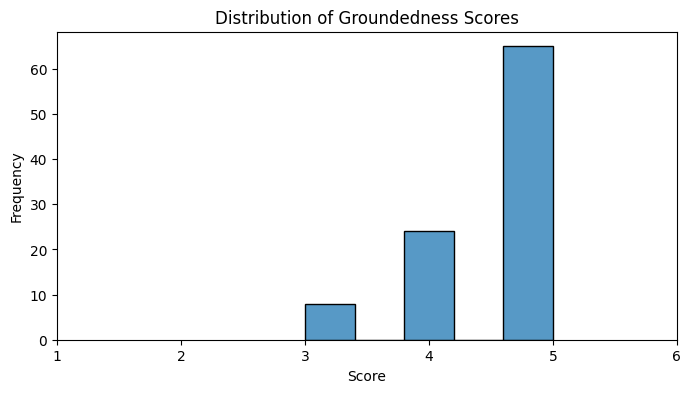

In [102]:

plot_evaluation_distribution(generated_questions_cleaned_media_llama, "groundedness_score", "Distribution of Groundedness Scores")


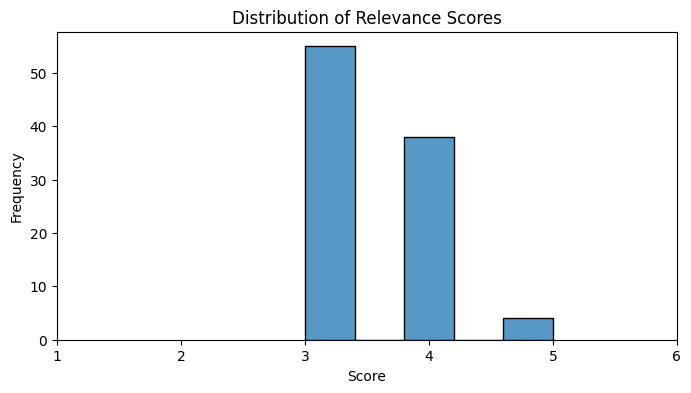

In [103]:
plot_evaluation_distribution(generated_questions_cleaned_media_llama, "relevance_score", "Distribution of Relevance Scores")


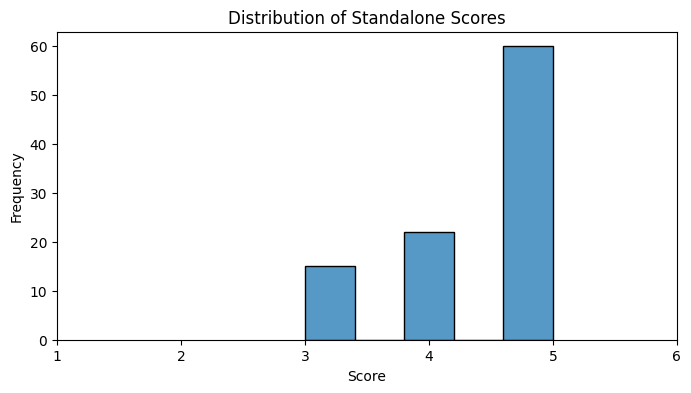

In [104]:
plot_evaluation_distribution(generated_questions_cleaned_media_llama, "standalone_score", "Distribution of Standalone Scores")


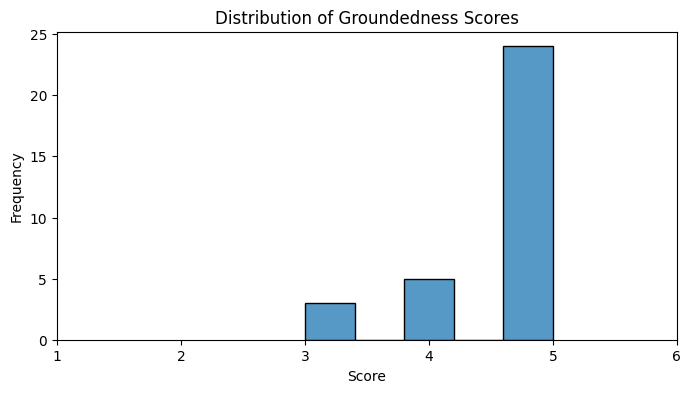

In [105]:
plot_evaluation_distribution(generated_questions_cleaned_patent_llama, "groundedness_score", "Distribution of Groundedness Scores")


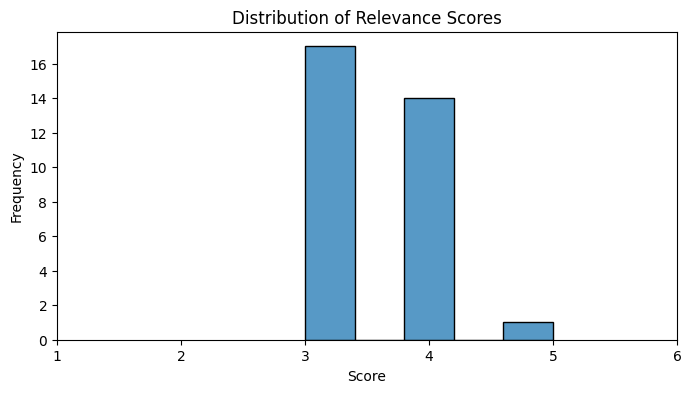

In [106]:
plot_evaluation_distribution(generated_questions_cleaned_patent_llama, "relevance_score", "Distribution of Relevance Scores")


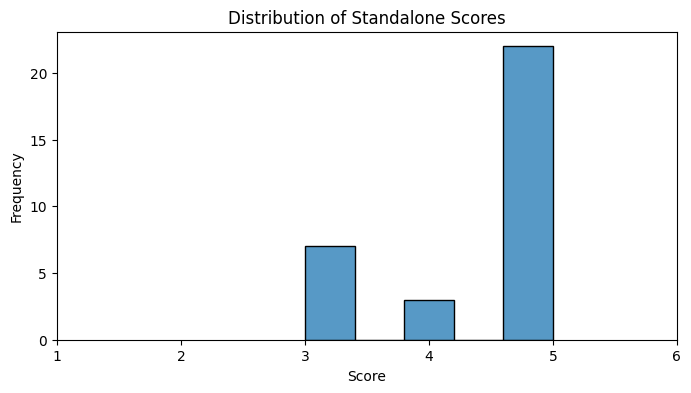

In [107]:
plot_evaluation_distribution(generated_questions_cleaned_patent_llama, "standalone_score", "Distribution of Standalone Scores")

### Evaluation of the Human Evaluation Dataset Analysis

In addition to our generated QA pairs, we evalutate the human evaluation dataset(cleantech_rag_evaluation_data_2024-09-20.csv). This dataset is a small, high-quality evaluation set designed to benchmark the retrieval step in the RAG system. The human evaluators have already curated these 28 examples for quality.

We pass this dataset through our classification and evaluation pipeline to see how well our automated QA evaluation compares. After running the examples through the pipeline (which includes our LLM-based critique agents and filtering logic), we found that only 4 out of the 28 examples were classified as good.

This outcome highlights a few key insights:

  - High Standards for Quality:
  Our pipeline uses strict evaluation metrics for groundedness, relevance, and standalone clarity. The fact that only 2 examples met our threshold indicates that these metrics are effective at distinguishing high quality QA pairs from those that are ambiguous, irrelevant, or overly context dependent.

  - Differences in Human vs. Automated Judgment:
  Although the human evaluation dataset is curated for quality, our automated critique agents may apply slightly different standards. This gap can arise due to the inherent differences between human judgment and the deterministic nature of our LLM-based scoring.

  - Potential Areas for Improvement:
  The low pass rate (2/28) suggests that even the high-quality human-curated examples can sometimes fall short of our strict automatic evaluation criteria. This may be due to subtle issues in the questions or context that our models pick up on. It also indicates that our QA generation and evaluation techniques could be further fine-tuned to align better with human judgments.

  - Implications for the Retrieval Step:
  Since this evaluation dataset is specifically for assessing the Retrieval component of our RAG system, maintaining a high-quality benchmark is crucial. Even though our automated pipeline filters aggressively, ensuring that the retrieval component consistently returns the top-quality examples is a key factor in the overall system performance.

In summary, processing the human evaluation dataset demonstrates the robustness of our filtering and quality control process, while also revealing areas where our automated system might differ from human expectations. This insight is valuable for tuning both our QA generation methods and our evaluation criteria to create an optimal RAG system.


In [79]:
human_eval.head(3)[['question','relevant_text','answer','article_url']]

,question,relevant_text,answer,article_url
0,What is the innovation behind LeclanchÃ©'s new method to produce lithium-ion batteries?,LeclanchÃ© said it has developed an environmentally friendly way to produce lithium-ion (Li-ion)...,LeclanchÃ©'s innovation is using a water-based process instead of highly toxic organic solvents ...,https://www.sgvoice.net/strategy/technology/23971/leclanches-new-disruptive-battery-boosts-energ...
1,What is the EUâs Green Deal Industrial Plan?,The Green Deal Industrial Plan is a bid by the EU to make its net zero industry more competitive...,The EUâs Green Deal Industrial Plan aims to enhance the competitiveness of its net zero indust...,https://www.sgvoice.net/policy/25396/eu-seeks-competitive-boost-with-green-deal-industrial-plan/
2,What is the EUâs Green Deal Industrial Plan?,The European counterpart to the US Inflation Reduction Act (IRA) aims to create an environment t...,The EUâs Green Deal Industrial Plan aims to enhance the competitiveness of its net zero indust...,https://www.pv-magazine.com/2023/02/02/european-commission-introduces-green-deal-industrial-plan/


In [109]:

dfs = [human_eval]

human_eval_categorized_sentence_bert = stack_and_categorize(dfs)

In [111]:
human_eval_categorized_sentence_bert.head(3)[['question','relevant_text','answer','article_url']]

,question,relevant_text,answer,article_url
0,What is the innovation behind LeclanchÃ©'s new method to produce lithium-ion batteries?,LeclanchÃ© said it has developed an environmentally friendly way to produce lithium-ion (Li-ion)...,LeclanchÃ©'s innovation is using a water-based process instead of highly toxic organic solvents ...,https://www.sgvoice.net/strategy/technology/23971/leclanches-new-disruptive-battery-boosts-energ...
1,What is the EUâs Green Deal Industrial Plan?,The Green Deal Industrial Plan is a bid by the EU to make its net zero industry more competitive...,The EUâs Green Deal Industrial Plan aims to enhance the competitiveness of its net zero indust...,https://www.sgvoice.net/policy/25396/eu-seeks-competitive-boost-with-green-deal-industrial-plan/
2,What is the EUâs Green Deal Industrial Plan?,The European counterpart to the US Inflation Reduction Act (IRA) aims to create an environment t...,The EUâs Green Deal Industrial Plan aims to enhance the competitiveness of its net zero indust...,https://www.pv-magazine.com/2023/02/02/european-commission-introduces-green-deal-industrial-plan/


In [112]:
outputs_human_eval = generate_output_list(human_eval_categorized_sentence_bert,name= 'human_eval')

In [116]:
results_human_eval = pd.read_csv("datasets/results_human_eval.csv")

In [121]:
results_human_eval = create_eval(outputs_human_eval)

In [ ]:
results_human_eval.to_csv("data/results_human_eval.csv")

In [117]:
evaluated_results = eval_qa_pairs(results_human_eval)

Evaluation dataset before filtering (showing first 5 rows):


,question,answer,groundedness_score,groundedness_eval,relevance_score,relevance_eval,standalone_score,standalone_eval
0,What is the innovation behind LeclanchÃ©'s new method to produce lithium-ion batteries?,LeclanchÃ©'s innovation is using a water-based process instead of highly toxic organic solvents ...,3,"The evaluation does not provide a clear understanding of the innovation, as the context only men...",1,"The question asks about a specific innovation related to lithium-ion batteries, which is a techn...",1,"The question implies that the reader is familiar with Leclanché, a company, and its products, sp..."
1,What is the EUâs Green Deal Industrial Plan?,The EUâs Green Deal Industrial Plan aims to enhance the competitiveness of its net zero indust...,5,The context provides sufficient information about the purpose and objectives of the EU's Green D...,2,The given question appears to be a factual query about a specific policy initiative by the Europ...,1,"The question explicitly mentions ""the EU's"" which indicates a reference to the European Union an..."
2,What is the EUâs Green Deal Industrial Plan?,The EUâs Green Deal Industrial Plan aims to enhance the competitiveness of its net zero indust...,4,"Based on the given context, it is clear that the question is related to the EU's environmental a...",2,The question seems to be relatively vague and does not directly relate to NLP or the Hugging Fac...,4,"The question refers to the European Union's policy, specifically mentioning ""EU"", a context-depe..."
3,What are the four focus areas of the EU's Green Deal Industrial Plan?,"The four focus areas of the EU's Green Deal Industrial Plan are the regulatory environment, acce...",5,The context provides a clear and concise description of the four focus areas of the EU's Green D...,2,"This question appears to be brief and informative, covering a specific topic related to a well-k...",5,"The question uses a specific and well-known term (""EU's Green Deal Industrial Plan"") that refere..."
4,When did the cooperation between GM and Honda on fuel cell vehicles start?,July 2013,5,The question about when the cooperation between GM and Honda on fuel cell vehicles started can b...,2,The question about the cooperation between GM and Honda on fuel cell vehicles is a relatively sp...,1,"The question implicitly refers to a well-known partnership between the companies, but it is not ..."


Final evaluation dataset (showing first 5 rows):


,question,answer,groundedness_score,relevance_score,standalone_score
11,Why are milder winters detrimental for grapes and apples?,Milder winters are detrimental for grapes and apples because these perennial species rely on con...,4,3,4
17,What is Agrivoltaics?,the integration of food production and solar energy to make better use of limited land and soil ...,4,4,5
18,What is Agrivoltaics?,the integration of food production and solar energy to make better use of limited land and soil ...,5,4,5
20,What are the obstacles for cannabis producers when it comes to using solar energy?,"limited access to financial instruments, inability to secure standard loans or mortgages, lack o...",4,3,5


In [118]:
len(evaluated_results)

4

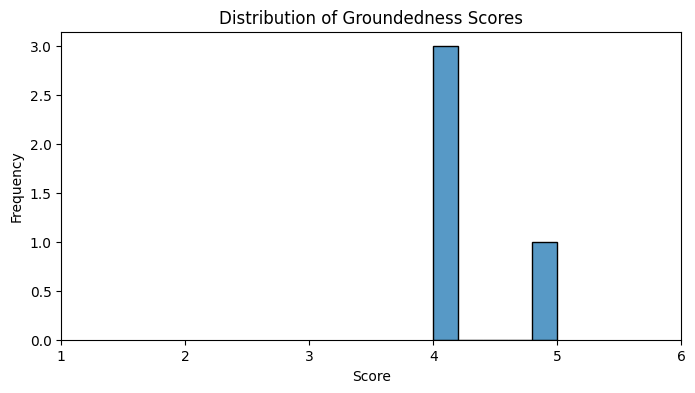

In [119]:
plot_evaluation_distribution(evaluated_results, "groundedness_score", "Distribution of Groundedness Scores")


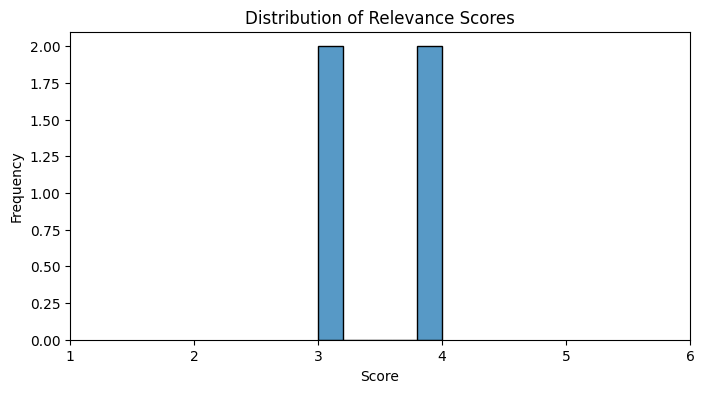

In [120]:
plot_evaluation_distribution(evaluated_results, "relevance_score", "Distribution of Relevance Scores")


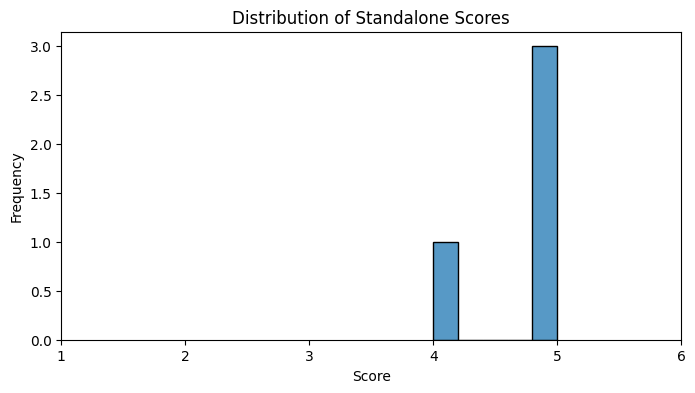

In [121]:
plot_evaluation_distribution(evaluated_results, "standalone_score", "Distribution of Standalone Scores")

## 8. Conclusion & Next Steps

In this notebook, we explored the process of creating and analyzing QA pairs from 50–100 carefully selected paragraphs from the Cleantech Media and Google Patent datasets. By generating, classifying, and rigorously evaluating these QA pairs using LLMs, we built a high-quality dataset that serves as a robust foundation for our RAG pipeline.

Next Steps:

  - Integrate the filtered QA dataset into the implemeted RAG system.

  - Experiment with different LLM prompts and filtering thresholds to refine your QA pair quality.

  - Use the insights gained from the evaluation visualizations to further tune your retrieval and generation processes.